# Загрузка и трансформация данных

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Matplolib default parameters
from matplotlib import rcParams
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

# import warning
import warnings
warnings.filterwarnings('ignore')

# Set option max columns display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics 
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

# %config InlineBackend.figure_format = 'retina'

# sns.set(style='whitegrid', palette='deep')

# plt.rcParams['figure.figsize'] = 8, 5
# plt.rcParams['font.size'] = 12
# plt.rcParams['savefig.format'] = 'pdf'

## Загружаем сырые данные

In [3]:
df_2023 = pd.read_excel('full_dfs/df_2023_full.xlsx')
df_2021 = pd.read_excel('full_dfs/df_2021_full.xlsx')
df_2020 = pd.read_excel('full_dfs/df_2020_full.xlsx')
df_2019 = pd.read_excel('full_dfs/df_2019_full.xlsx')
df_bank_ids = pd.read_excel('full_dfs/bank_ids.xlsx')

In [4]:
df_2023.head()

,bank_name,Вложения в ценные бумаги,Кредитный портфель,Просроченная задолженность в кредитном портфеле,Активы нетто,Векселя,Вклады физических лиц,Вложения в акции,Вложения в векселя,Вложения в капиталы других организаций,Вложения в облигации,Выданные МБК,Выпущенные облигации и векселя,Высоколиквидные активы,Капитал (по форме 123),Кредиты предприятиям и организациям,Кредиты физическим лицам,ЛОРО-счета,НОСТРО-счета,Облигации,Основные средства и нематериальные активы,Привлеченные МБК,Привлеченные от ЦБ РФ,Прочие активы,Размещенные МБК в ЦБ РФ,Средства предприятий и организаций,ФЛ Счета,Чистая прибыль,Н1,Н2,Н3,Уровень просроченной задолженности по кредитному портфелю
0,Сбербанк,6.292502e+09,3.656594e+10,155268282.0,50695718774,77202098,11458178474,45827036,580517,1270984158,6246094682,1016170304,721975229,2837424377,6009350522,21633325789,14850451930,339939079,1423010926,644773131,676395335,3637628709,1070440895,2036300583,0,13751643094,3645562530,1377559523,13.01,64.92,86.28,0.43
1,ВТБ,4.693619e+09,1.573751e+10,135018281.0,26188218945,44638934,4579261369,83808718,0,1072255743,4609809811,760271572,189180751,1376307864,1708020297,10617616212,5119891167,173067676,1005731610,144541817,665718343,3542435806,1395688627,1882539515,0,11575806309,1925335464,185532759,9.46,60.91,80.50,0.86
2,Газпромбанк,1.471975e+09,1.024813e+10,58494498.0,15296029418,106779045,1592032837,26906711,0,541594156,1445068672,364484845,314108805,1913602084,1239268046,9512160750,730273235,74047563,1315819277,207329760,105302325,2201819423,479418376,650944656,0,7964930669,2538942392,239160122,11.02,90.13,66.72,0.57
3,Альфа-Банк,1.072772e+09,5.716990e+09,23056930.0,8411400483,22954997,1383959353,28971157,1000,15415862,1043800235,507862071,221421881,536528776,837421439,3558470596,1971280620,56002300,378309564,198466884,89438361,389493267,138860185,472392973,0,3376395087,1492431122,99718083,11.91,95.42,77.48,0.42
4,Московский кредитный банк (МКБ),8.645898e+08,3.129535e+09,29047964.0,4971033526,0,514246382,20754861,0,8056345,843834949,497847392,30659871,255921811,380444881,2865652689,211538402,92450104,233877937,30659871,9833444,1173420446,60881212,205249448,60000000,2298140312,277308455,41144717,12.07,90.83,66.29,0.94


In [5]:
df_2023['bank_name'].nunique()

339

## Рассчет ROA, ROE для 2021 - 2023 годов

In [6]:
df_2023['ROA'] = df_2023['Чистая прибыль'] / df_2023['Активы нетто']
df_2023['ROE'] = df_2023['Чистая прибыль'] / df_2023['Капитал (по форме 123)']

In [7]:
df_2023 = df_2023.rename(columns = {
                          'Уровень просроченной задолженности по кредитному портфелю' : 'NPL Ratio',
                          'Н2' : 'Н2 liquidity',
                          'Н3' : 'Н3 liquidity',
                          'Н1' : 'Н1 CAR',
                          'Активы нетто': 'Total Assets',
                          'Капитал (по форме 123)' : 'Капитал'})

Создаем дополнительные переменные:
- Банк государственный или частный `gos_sobstv`
- Банк инострынный или отечественный `foreign`
- Банк системнозначимый или не `system`

In [8]:
from clustering_functions import labels_2021_2023
df_2021 = labels_2021_2023(df_2021)
df_2023 = labels_2021_2023(df_2023)

## Некоторые соображения по поводу признаков дял кластеризации

Banks’ risk clustering using k-means: a method based on size and individual & systemic risks
https://drive.google.com/file/d/1FM3AV05f2CrFG5oDe0lKZ3H9cftbDheo/view

The factor called __RatioBS__ measures banks’ exposures using balance sheet ratios, such as: 
- ??? `debt / total assets` <br>
__debt__ = long term borrowings (*Кредиты сроком более 1 года ЮЛ + ФЛ*) + short term borrowings (*Кредиты сроком до 1 года ЮЛ + ФЛ*) + securities sold with repurchase agreements (*Бумаги переданные в РЕПО*). <br>
total assets = *Активы нетто*
- `deposit / total assets` <br>
__deposit__ = total deposits received from customers (*ФЛ Счета + ЮЛ Счета?*)
- `total loans / total assets` - It shows to what extent a bank is engaged in non-classical banking activities. If the value is low, then a bank has a high interbank or trading exposure.<br> 
total loans = *Кредиты физическим лицам + Кредиты предприятиям и организациям + Выданные МБК*. 
- `total loans / deposit` - LDR <br>
LDR > 1 => банк выдает больше кредитов, чем получает в виде депозитов от клиентов. Это может указывать на то, что банк дополнительно финансирует свои кредитные операции через другие источники, такие как межбанковское кредитование или выпуск облигаций.<br>
LDR < 1 => банк получает больше депозитов, чем выдает в виде кредитов. Это может указывать на более консервативную стратегию финансирования и уровень ликвидности банка.
- `non-performing assets / total assets` <br> 
__Non-performing assets__ are composed of non-accrual loans, restructured loans and foreclosed real estate <br>
non-performing assets 
- `non-performing-loans / total loans` <br>
 __non-performing-loans__ =  those in default or close to default. (просрочка) *ФЛ Просроченная задолженность* + *ЮЛ Просроченная задолженность*
- `reserve for loan loss / total loans` 

The __CreditBS__ factor assesses banks’ credit worthiness based on balance
sheet information, such as:
- `common equity / total assets` 
- `ROA` 
- `price / book ratio` = bank’s market capitalization / its common equity.
- `Texas ratio` = bank’s non-performing assets / (reserve for loan loss + total equity). total equity = Капитал по форме 123
- `Z-score` Simple and popular risk measure of a bank’s probability of insolvency.


We also build the __RegCapital__ factor highlighting the main Basel’s capital ratios:
- Tier 1 capital ratio, 
- total risk-based capital ratio, capital adequacy ratio (CAR)
- risk-weighted-asset / total assets. 


__Украинская статья__ <br>
- `retail loans / revenue generating assets` - A high value of this variable evidences that a bank serves individuals mainly. If the value is low, a bank orients more on
the corporate or wholesale market
- `retail funding / overal liabilities - subordinate debt` - it shows to what extent a bank relies on individuals to fund its operations

- Средняя ставка по кредитам ?
- Средняя ставка по депозитам ?
- Разница между ними ?

credit risk:
- `NPL ratio` - колонка Уровень просроченной задолженности по кредитному портфелю
- `NPL coverage` - колонка Уровень резервирования по кредитному портфелю


__Using clustering ensemble to identify banking business models__
Делят все показатели на total assets, а сами total assets логарифмируют
- Кредиты предприятиям и организациям / Активы нетто
- Кредиты физическим лицам / Активы нетто
- Выданные МБК / Активы нетто
- (ФЛ Счета + ЮЛ Счета) / Активы нетто
- Привлеченные МБК / Активы нетто
- log(Активы нетто)
- Капитал (по форме 123) / Активы нетто

Переменные риска

Работа 2 (Иранские банки)<br>

- Показатель LADD - риск ликвидности. Вместо него в нашей работе 2 показателя __H2__ и __H3__ <br>
(LADD = - (Liquidity Asset) / Demand deposit)

- Z-score. __H1__ - минимальная величина собственных средств (капитала) банка, необходимых для покрытия кредитного и рыночного рисков  = total equities / total assets ?<br>
![](https://i.imgur.com/4NpU0FR.png) 
Чем меньше Z-score, тем рискованнее банк


•	`Total Assets / No of branches` – собрать кол-во бранчей для каждого банка (актуально для 2023 года будет, а на предыдущие года можно экстраполировать посчитать в % от отделений 2023) 

https://www.banki.ru/banks/ - ссылка для этого

The Assets/Branches variable shows how intensively the bank uses a chain of branches in its opera􀆟 ons. Since we did not want this variable to implicitly represent banks’ size, we standardized it by assets value. In the results, the variable shows assets’ value per branch. A high value is supposed to indicate a rela􀆟 vely small number of branches.

## Переводим в отрезок [0,1] некоторые показатели:

In [9]:
#процентные колонки
for col in ['Н1','Н2', 'Н3', 'Рентабельность активов-нетто', 'Рентабельность капитала',
       'Уровень обеспечения кредитного портфеля залогом имущества',
        'Уровень просроченной задолженности по кредитному портфелю',
       'Уровень резервирования по кредитному портфелю']:
    df_2019[col] = df_2019[col] / 100
    df_2020[col] = df_2020[col] / 100
    df_2021[col] = df_2021[col] / 100

df_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity']] = df_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity']] / 100

## Рассчет признака Z-score:

In [10]:
df_roa_2016 = pd.read_excel('full_dfs/roa_2016.xlsx')
df_roa_2016 = df_roa_2016.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2016'})
df_roa_2016['ROA_2016'] = df_roa_2016['ROA_2016'] / 100
df_roa_2016 = df_roa_2016[['bank_name', 'ROA_2016']]

df_roa_2017 = pd.read_excel('full_dfs/roa_2017.xlsx')
df_roa_2017 = df_roa_2017.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2017'})
df_roa_2017['ROA_2017'] = df_roa_2017['ROA_2017'] / 100
df_roa_2017 = df_roa_2017[['bank_name', 'ROA_2017']]

df_roa_2018 = pd.read_excel('full_dfs/roa_2018.xlsx')
df_roa_2018 = df_roa_2018.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2018'})
df_roa_2018['ROA_2018'] = df_roa_2018['ROA_2018'] / 100
df_roa_2018 = df_roa_2018[['bank_name', 'ROA_2018']]

df_roa_2019 = df_2019[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2019'})
df_roa_2020 = df_2020[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2020'})
df_roa_2021 = df_2021[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2021'})
df_roa_2023 = df_2023[['bank_name', 'ROA']].rename(columns = {'ROA' : 'ROA_2023'})

df_stdev_roas = df_roa_2021.merge(
    df_roa_2020, how='outer', on='bank_name').merge(
        df_roa_2019, how='outer', on='bank_name').merge(
            df_roa_2018, how='outer', on='bank_name').merge(
                df_roa_2017, how='outer', on='bank_name').merge(
                    df_roa_2016, how='outer', on='bank_name').merge(
                        df_roa_2023, how='outer', on = 'bank_name')

df_stdev_roas['std_ROA_2019'] = df_stdev_roas[['ROA_2019', 'ROA_2018', 'ROA_2017', 'ROA_2016']].std(axis=1)
df_stdev_roas['std_ROA_2020'] = df_stdev_roas[['ROA_2020', 'ROA_2019', 'ROA_2018', 'ROA_2017']].std(axis=1)
df_stdev_roas['std_ROA_2021'] = df_stdev_roas[['ROA_2021', 'ROA_2020', 'ROA_2019', 'ROA_2018']].std(axis=1)
df_stdev_roas['std_ROA_2023'] = df_stdev_roas[['ROA_2023', 'ROA_2021', 'ROA_2020', 'ROA_2019']].std(axis=1)

In [11]:
df_stdev_roas.head() #стандартные отклонения ROA для каждого банка

,bank_name,ROA_2021,ROA_2020,ROA_2019,ROA_2018,ROA_2017,ROA_2016,ROA_2023,std_ROA_2019,std_ROA_2020,std_ROA_2021,std_ROA_2023
0,Сбербанк,0.0350,0.0249,0.0310,0.0326,0.0298,0.0229,0.027173,0.004273,0.003321,0.004309,0.004437
1,ВТБ,0.0143,0.0037,0.0130,0.0177,0.0105,0.0081,0.007085,0.004104,0.005837,0.005987,0.004992
2,Газпромбанк,0.0168,0.0044,0.0099,0.0049,0.0073,0.0066,0.015635,0.002077,0.002524,0.005763,0.005716
3,Альфа-Банк,0.0271,0.0420,0.0190,0.0335,0.0161,-0.0012,0.011855,0.014239,0.012225,0.009747,0.012938
4,Московский кредитный банк (МКБ),0.0090,0.0045,0.0219,0.0027,0.0049,-0.0005,0.008277,0.010015,0.008984,0.008665,0.007582


In [12]:
df_stdev_roas.isna().sum() #смотрим количество пропусков

bank_name        0
ROA_2021        24
ROA_2020        19
ROA_2019        42
ROA_2018        15
ROA_2017        22
ROA_2016        26
ROA_2023        12
std_ROA_2019    15
std_ROA_2020    13
std_ROA_2021    15
std_ROA_2023    15
dtype: int64

## Создаем остальные осмысленные переменные для кластеризации:

In [38]:
from clustering_functions import preprocess_data_2019_2021, preprocess_data2023

# помимо создания признаков переводим Z-score и NPL Ratio, LDR в отрезок [0, 1] - мб не надо?
x_2023 = preprocess_data2023(dataframe = df_2023, df_stdev_roas = df_stdev_roas)

x_2021 = preprocess_data_2019_2021(dataframe = df_2021, df_stdev_roas = df_stdev_roas, year = 2021)
x_2020 = preprocess_data_2019_2021(dataframe = df_2020, df_stdev_roas = df_stdev_roas, year = 2020)
x_2019 = preprocess_data_2019_2021(dataframe = df_2019, df_stdev_roas = df_stdev_roas, year = 2019)

In [39]:
x_2023.head() # таблица с подготовленными признаками для кластеризации

,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
0,0.1301,0.6492,0.8628,0.027173,0.229236,0.000498,0.497277,0.739706,0.000316,0.055970,0.018027,0.426729,0.292933,0.020044,0.071754,0.118538,24.649107,1.0,0.0,1.0
1,0.0946,0.6091,0.8050,0.007085,0.108624,0.000996,0.616883,0.629969,0.000217,0.052554,0.010801,0.405435,0.195504,0.029031,0.135268,0.065221,23.988575,1.0,0.0,1.0
2,0.1102,0.9013,0.6672,0.015635,0.192985,0.000660,0.624800,0.693443,0.000236,0.125104,0.011589,0.621871,0.047743,0.023829,0.143947,0.081019,23.450859,1.0,0.0,0.0
3,0.1191,0.9542,0.7748,0.011855,0.119078,0.000486,0.565941,0.717789,0.000270,0.063786,0.005887,0.423053,0.234358,0.060378,0.046305,0.099558,22.852854,0.0,0.0,1.0
4,0.1207,0.9083,0.6629,0.008277,0.108149,0.001088,0.565755,0.719174,0.000270,0.051483,0.009191,0.576470,0.042554,0.100150,0.236052,0.076532,22.326894,0.0,0.0,1.0


In [24]:
# df_2023.columns

In [25]:
# 'Привлеченные МБК' + 'Средства предприятий и организаций' + 'Вклады физических лиц'

In [26]:
#Таблица с именем банка и выборкой для кластеризации

In [40]:
x_2023['bank_name'] = df_2023['bank_name']
temp_cols = x_2023.columns.to_list()
new_cols = temp_cols[-1:] + temp_cols[:-1]
x_2023 = x_2023[new_cols]

In [41]:
# x_2023 = x_2023.drop(columns = 'Debt/TotalAssets')

In [42]:
x_2023.to_excel('full_dfs/x_2023.xlsx', index = False)

In [46]:
x_2023['LDR'].value_counts().reset_index().sort_values(by = 'LDR', ascending = False)

,LDR,count
137,1.000000e+00,1
114,5.779390e-01,1
93,1.602482e-01,1
312,5.999738e-02,1
107,3.062125e-02,1
...,...,...
148,2.039682e-05,1
178,9.480060e-06,1
96,3.455984e-07,1
313,1.275981e-07,1


# EDA 2023

In [26]:
%config InlineBackend.figure_format = 'retina'

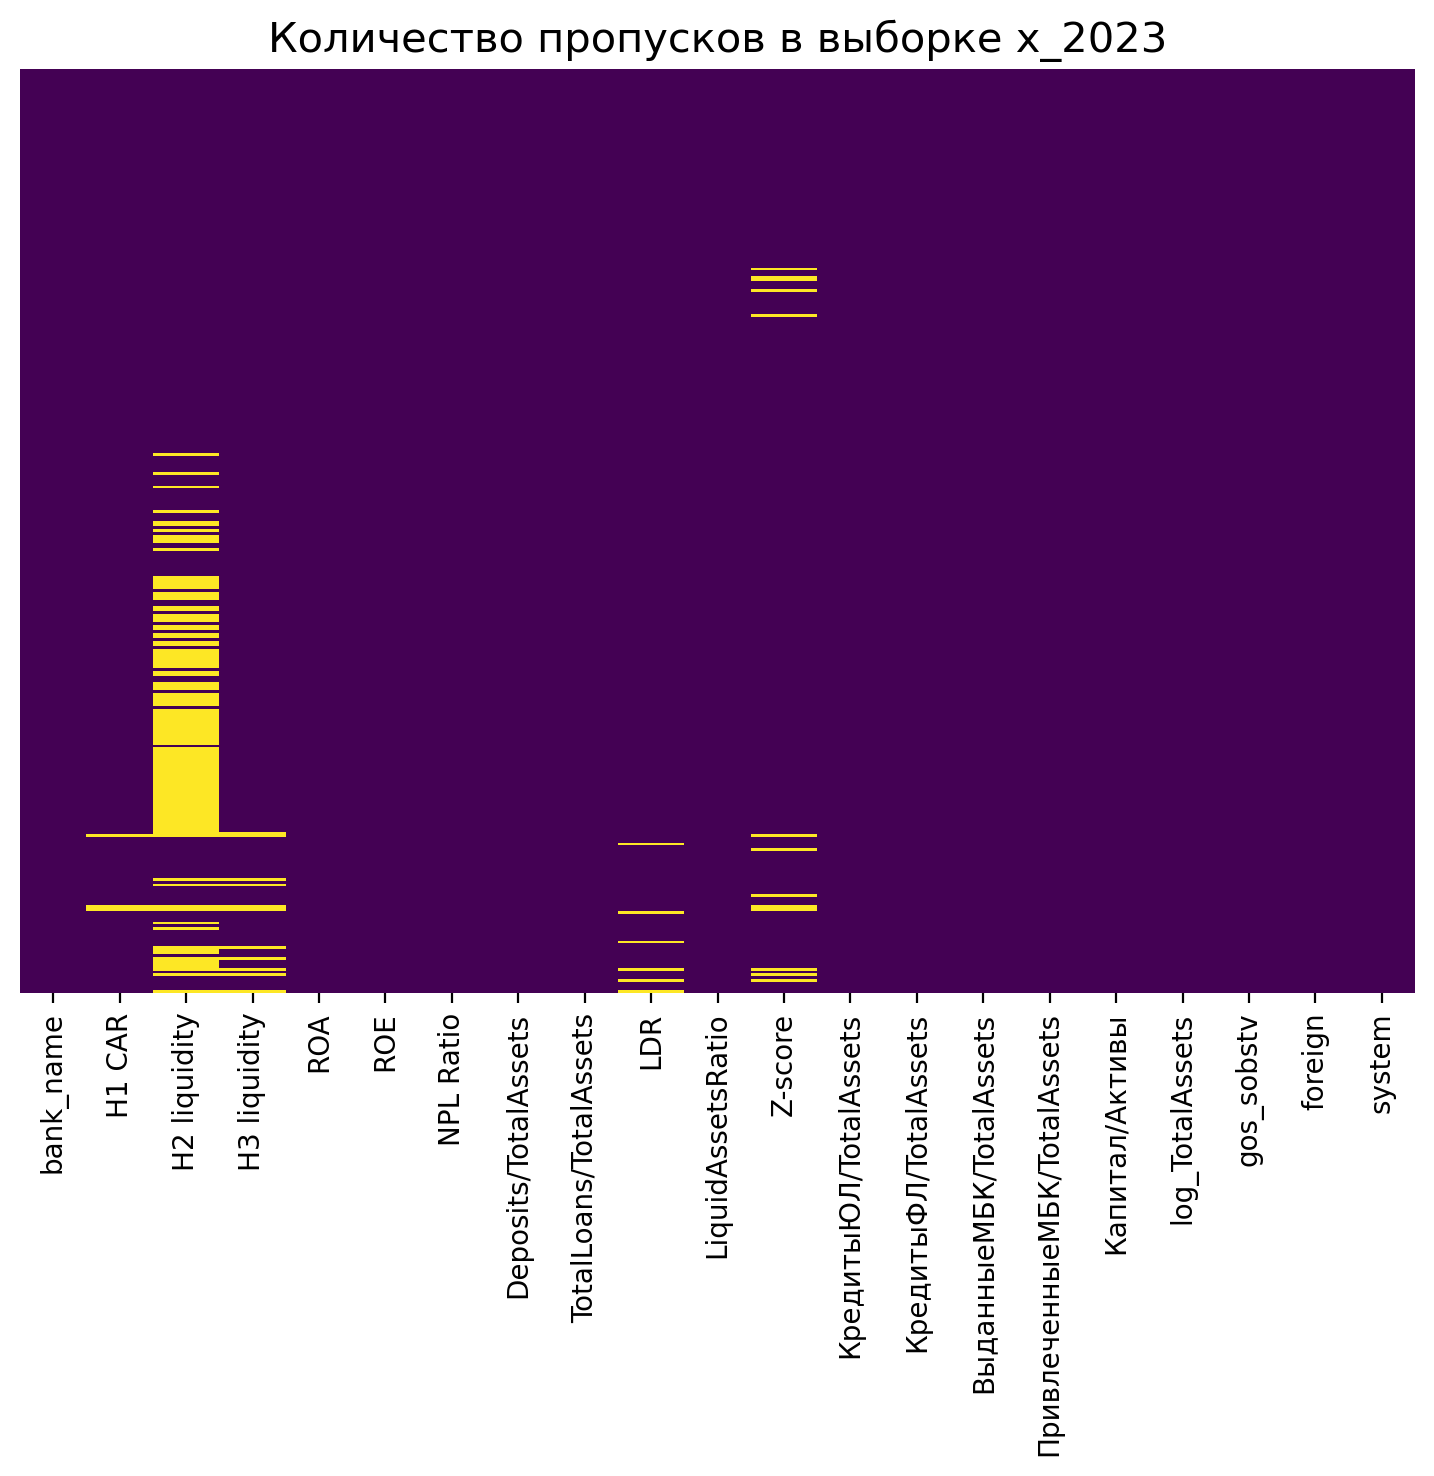

In [196]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set_title('Количество пропусков в выборке x_2023', fontsize=15)
sns_heatmap = sns.heatmap(x_2023.isnull(),
                          yticklabels=False,
                          cbar=False,
                          cmap='viridis')

In [31]:
# описательная таблица
list_item = []
for col in x_2023.columns:
    list_item.append([col, x_2023[col].dtype, x_2023[col].isna().sum(), 100*x_2023[col].isna().sum()/len(x_2023[col]), x_2023[col].nunique(), x_2023[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,bank_name,object,0,0.000000,339,"[Сбербанк, ВТБ, Газпромбанк, Альфа-Банк]"
1,Н1 CAR,float64,3,0.884956,325,"[0.1301, 0.0946, 0.11019999999999999, 0.1191]"
2,Н2 liquidity,float64,109,32.153392,214,"[0.6492, 0.6091, 0.9013, 0.9542]"
3,Н3 liquidity,float64,11,3.244838,312,"[0.8628, 0.805, 0.6672, 0.7748]"
4,ROA,float64,0,0.000000,339,"[0.027173093829503024, 0.007084588661399707, 0..."
5,ROE,float64,0,0.000000,339,"[0.22923600777768044, 0.1086244462819753, 0.19..."
6,NPL Ratio,float64,0,0.000000,131,"[0.0004979099361980524, 0.0009958198723961048,..."
7,Deposits/TotalAssets,float64,0,0.000000,334,"[0.49727713064656665, 0.6168830233139782, 0.62..."
8,TotalLoans/TotalAssets,float64,0,0.000000,337,"[0.7397064077575002, 0.6299694906953512, 0.693..."
9,LDR,float64,6,1.769912,332,"[1.4875134249502358, 1.021213855604375, 1.1098..."


In [24]:
desc_df.to_excel('desc_df.xlsx', index = False)

In [48]:
from clustering_functions import visuals_boxplot, visuals_kdeplot, visuals_violinplot

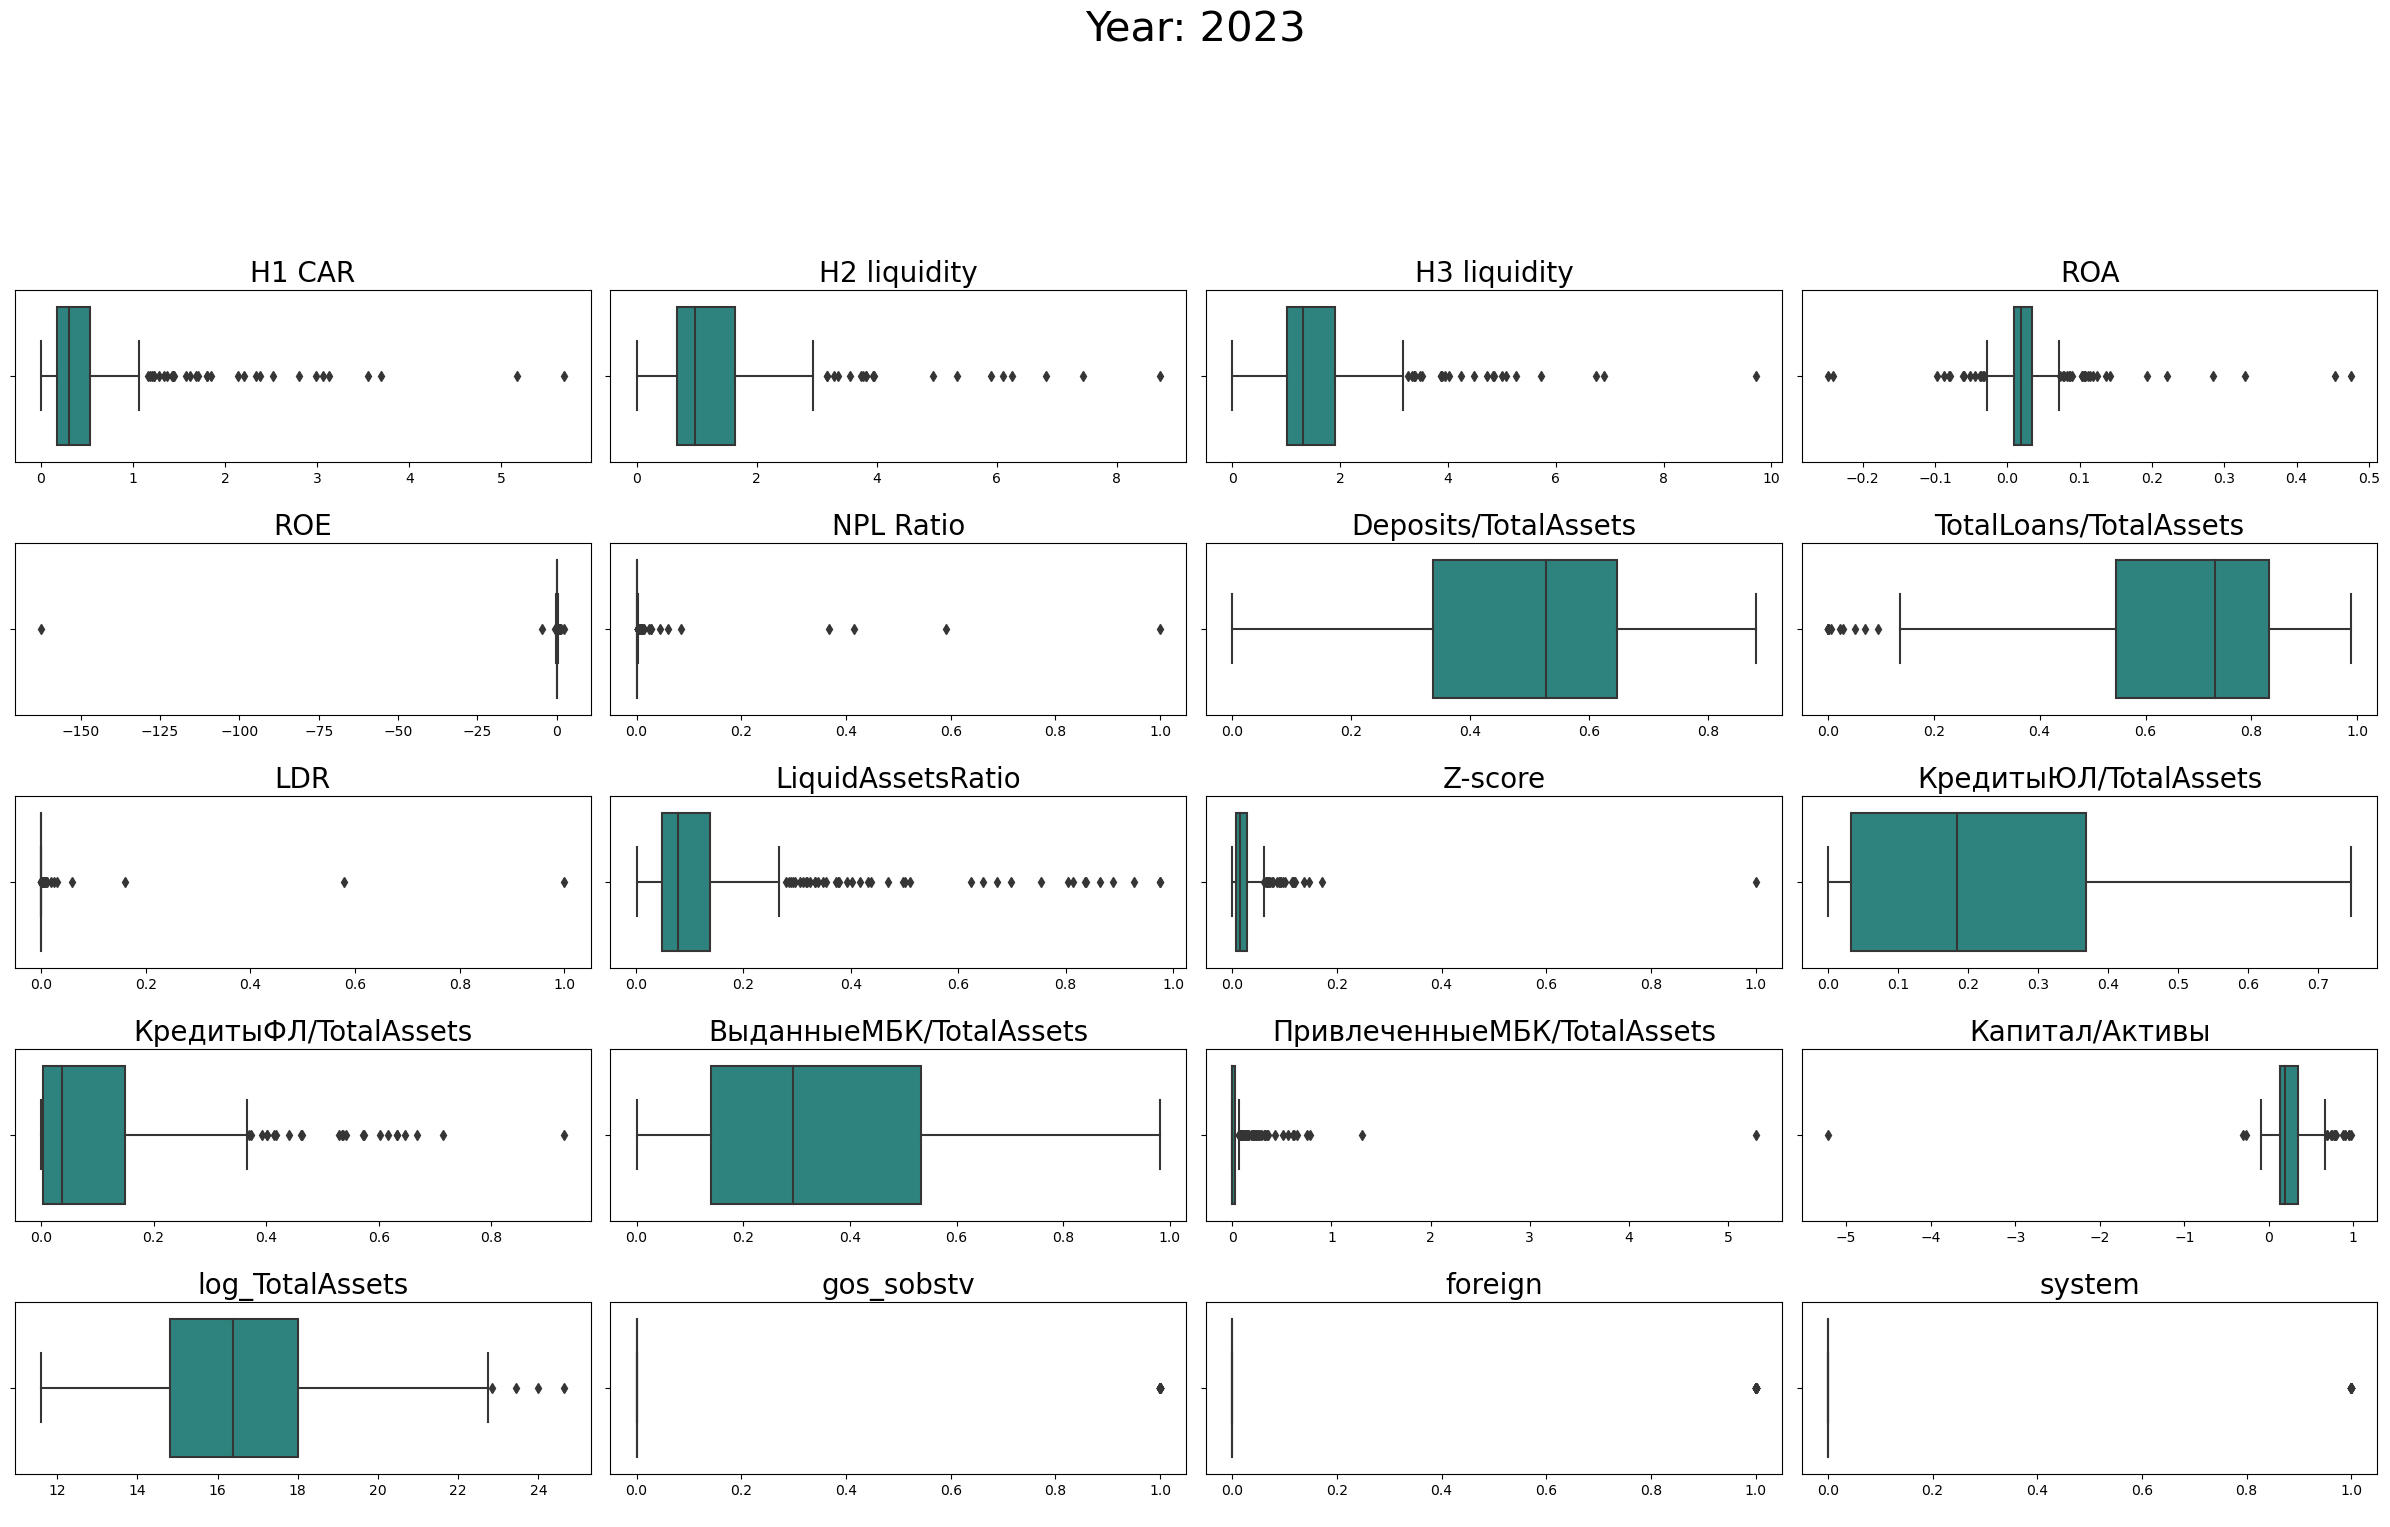

In [49]:
visuals_boxplot(x_2023.drop(columns = 'bank_name'), year=2023)

- Есть яркие выбросы =>  с ними что-то надо сделать

Газэнергобанк

In [50]:
x_2023[x_2023['ROE'] == x_2023['ROE'].min()]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
43,Газэнергобанк,0.0002,0.7302,1.0733,-0.021013,-162.453643,0.001806,0.395945,0.594308,0.000319,0.048238,0.0,0.162568,0.124662,0.307077,0.557946,0.000129,18.79173,0.0,0.0,0.0


In [59]:
df_stdev_roas[df_stdev_roas['bank_name'] == 'Газэнергобанк']

,bank_name,ROA_2021,ROA_2020,ROA_2019,ROA_2018,ROA_2017,ROA_2016,ROA_2023,std_ROA_2019,std_ROA_2020,std_ROA_2021,std_ROA_2023
44,Газэнергобанк,-0.0036,-0.0195,NaN,0.0067,0.0084,0.0113,-0.021013,0.002326,0.01564,0.013199,0.009646


In [61]:
df_2023[df_2023['bank_name'] == 'Газэнергобанк']

,bank_name,Вложения в ценные бумаги,Кредитный портфель,Просроченная задолженность в кредитном портфеле,Total Assets,Векселя,Вклады физических лиц,Вложения в акции,Вложения в векселя,Вложения в капиталы других организаций,Вложения в облигации,Выданные МБК,Выпущенные облигации и векселя,Высоколиквидные активы,Капитал,Кредиты предприятиям и организациям,Кредиты физическим лицам,ЛОРО-счета,НОСТРО-счета,Облигации,Основные средства и нематериальные активы,Привлеченные МБК,Привлеченные от ЦБ РФ,Прочие активы,Размещенные МБК в ЦБ РФ,Средства предприятий и организаций,ФЛ Счета,Чистая прибыль,Н1 CAR,Н2 liquidity,Н3 liquidity,NPL Ratio,ROA,ROE,gos_sobstv,foreign,system,Debt/TotalAssets,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR
43,Газэнергобанк,42644851.0,41626983.0,650924.0,144925461,0,17083904,17691,0,0,42627160,44503340,0,6990960,18746,23560261,18066722,1852278,4421004,0,1367603,80860646,0,7791724,0,40298554,3055299,-3045356,0.0002,0.7302,1.0733,1.56,-0.021013,-162.453643,0,0,0,0.28723,0.395945,0.594308,1.500987


«ИНЭКО»

In [161]:
x_2023[x_2023['Z-score'] == x_2023['Z-score'].max()]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
338,«ИНЭКО»,5.6838,NaN,NaN,0.003576,0.003791,0.0,0.0,0.791719,NaN,0.194786,2083.537105,0.0,0.0,0.791719,0.0,0.943278,11.597055,0.0,0.0,0.0


In [67]:
df_stdev_roas[df_stdev_roas['bank_name'] == '«ИНЭКО»']

,bank_name,ROA_2021,ROA_2020,ROA_2019,ROA_2018,ROA_2017,ROA_2016,ROA_2023,std_ROA_2019,std_ROA_2020,std_ROA_2021,std_ROA_2023
329,«ИНЭКО»,0.0012,0.0003,0.0064,-0.0187,NaN,NaN,0.003576,0.017748,0.013091,0.011,0.00273


Таврический Банк

In [55]:
x_2023[x_2023['NPL Ratio'] == x_2023['NPL Ratio'].max()]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
50,Таврический Банк,0.0,1.1871,0.5366,0.085155,-0.316912,1.0,0.649379,0.028961,0.000009,0.033815,0.002202,0.023142,0.00579,0.000029,0.657784,-0.268702,18.648918,0.0,0.0,0.0


In [165]:
x_2023[x_2023['NPL Ratio'] > x_2023['NPL Ratio'].quantile(0.99)]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
20,БМ-Банк,0.5447,6.2623,3.8804,0.029198,0.088995,510.89,0.516158,0.677866,1.313290,0.002720,116.741278,0.000919,0.003022,0.673925,0.000000,0.328087,20.107696,1.0,0.0,0.0
50,Таврический Банк,0.0000,1.1871,0.5366,0.085155,-0.316912,863.61,0.649379,0.028961,0.044598,0.033815,2.434192,0.023142,0.005790,0.000029,0.657784,-0.268702,18.648918,0.0,0.0,0.0
286,Точка,0.1937,1.0522,0.9411,0.011530,0.312619,358.36,0.600765,0.135551,0.225631,0.836303,NaN,0.000002,0.000000,0.135549,0.000000,0.036881,19.424461,0.0,0.0,0.0
302,ИНКАХРАН,0.2194,0.0000,0.0000,0.009899,0.235434,318.01,0.000968,0.729949,753.874991,0.250914,8.599377,0.000007,0.000000,0.729942,0.000000,0.042044,17.198017,0.0,0.0,0.0


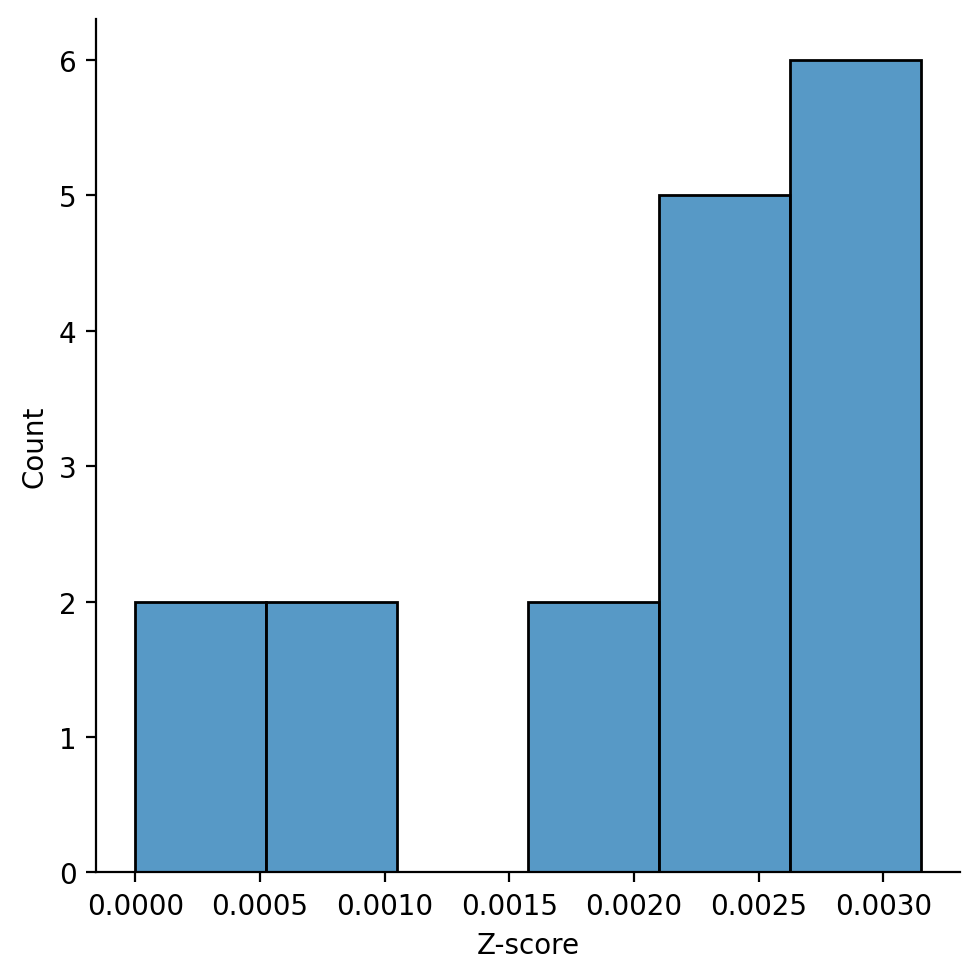

In [86]:
sns.displot(x_2023[(x_2023['Z-score'] < x_2023['Z-score'].quantile(0.05))]['Z-score'])

Траст банк

In [56]:
x_2023[x_2023['Капитал/Активы'] == x_2023['Капитал/Активы'].min()]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
30,«Траст»,0.0,0.3994,0.7723,0.328926,-0.063047,0.059865,0.00574,0.223759,0.008286,0.005143,0.001944,0.156184,0.00006,0.067515,5.277712,-5.217186,19.395601,0.0,0.0,0.0


In [168]:
x_2023[x_2023['Н1 CAR'] < 0.08]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
30,«Траст»,0.0000,0.3994,0.7723,0.328926,-0.063047,51.70,0.005740,0.223759,38.980307,0.005143,1.897723,0.156184,0.000060,0.067515,5.277712,-5.217186,19.395601,0.0,0.0,0.0
39,Инвестторгбанк,0.0000,3.9322,3.9462,0.000106,-0.001105,38.19,0.850419,0.409012,0.480953,0.038518,0.012384,0.188800,0.154700,0.065512,0.232782,-0.095838,18.990550,0.0,0.0,0.0
43,Газэнергобанк,0.0002,0.7302,1.0733,-0.021013,-162.453643,1.56,0.395945,0.594308,1.500987,0.048238,-2.157613,0.162568,0.124662,0.307077,0.557946,0.000129,18.791730,0.0,0.0,0.0
50,Таврический Банк,0.0000,1.1871,0.5366,0.085155,-0.316912,863.61,0.649379,0.028961,0.044598,0.033815,2.434192,0.023142,0.005790,0.000029,0.657784,-0.268702,18.648918,0.0,0.0,0.0
66,ВУЗ-банк,0.0000,0.3157,0.5590,-0.241509,0.804715,5.21,0.091934,0.653883,7.112538,0.028992,-1.612909,0.283661,0.340996,0.029226,1.305042,-0.300117,18.080130,0.0,0.0,0.0
75,ГЕНБАНК,0.0544,0.6076,2.3386,0.025244,0.718056,0.14,0.763299,0.477961,0.626177,0.039581,5.781128,0.199622,0.135709,0.142630,0.013824,0.035155,17.903079,0.0,0.0,0.0
76,Тимер Банк,0.0000,1.2826,5.2705,0.010245,-0.244046,6.22,0.880495,0.494632,0.561765,0.008137,NaN,0.151865,0.011013,0.331754,0.078658,-0.041979,17.892559,0.0,0.0,0.0
109,Экономбанк,0.0000,0.5876,0.8105,-0.012275,0.138698,72.66,0.822923,0.198193,0.240840,0.028800,-1.028934,0.195718,0.002475,0.000000,0.290136,-0.088502,17.093613,0.0,0.0,0.0


In [57]:
x_2023['Z-score'].quantile(0.05)

0.003156108045131095

In [58]:
x_revoked = pd.read_excel('x_revoked.xlsx')

In [59]:
df_bad = pd.concat([x_2023[x_2023['Н1 CAR'] < 0.08], x_revoked.drop(columns='Debt/TotalAssets')])

In [60]:
df_bad[['bank_name', 'Н1 CAR', 'Z-score']].to_excel('df_bad_banks.xlsx', index = False)

In [61]:
df_bad.columns

Index(['bank_name', 'Н1 CAR', 'Н2 liquidity', 'Н3 liquidity', 'ROA', 'ROE',
       'NPL Ratio', 'Deposits/TotalAssets', 'TotalLoans/TotalAssets', 'LDR',
       'LiquidAssetsRatio', 'Z-score', 'КредитыЮЛ/TotalAssets',
       'КредитыФЛ/TotalAssets', 'ВыданныеМБК/TotalAssets',
       'ПривлеченныеМБК/TotalAssets', 'Капитал/Активы', 'log_TotalAssets',
       'gos_sobstv', 'foreign', 'system'],
      dtype='object')

In [62]:
df_bad

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
30,«Траст»,0.0000,0.3994,0.7723,0.328926,-0.063047,0.059865,0.005740,0.223759,0.008286,0.005143,0.001944,0.156184,0.000060,0.067515,5.277712,-5.217186,19.395601,0.0,0.0,0.0
39,Инвестторгбанк,0.0000,3.9322,3.9462,0.000106,-0.001105,0.044221,0.850419,0.409012,0.000102,0.038518,0.001040,0.188800,0.154700,0.065512,0.232782,-0.095838,18.990550,0.0,0.0,0.0
43,Газэнергобанк,0.0002,0.7302,1.0733,-0.021013,-162.453643,0.001806,0.395945,0.594308,0.000319,0.048238,0.000000,0.162568,0.124662,0.307077,0.557946,0.000129,18.791730,0.0,0.0,0.0
50,Таврический Банк,0.0000,1.1871,0.5366,0.085155,-0.316912,1.000000,0.649379,0.028961,0.000009,0.033815,0.002202,0.023142,0.005790,0.000029,0.657784,-0.268702,18.648918,0.0,0.0,0.0
66,ВУЗ-банк,0.0000,0.3157,0.5590,-0.241509,0.804715,0.006033,0.091934,0.653883,0.001512,0.028992,0.000261,0.283661,0.340996,0.029226,1.305042,-0.300117,18.080130,0.0,0.0,0.0
75,ГЕНБАНК,0.0544,0.6076,2.3386,0.025244,0.718056,0.000162,0.763299,0.477961,0.000133,0.039581,0.003806,0.199622,0.135709,0.142630,0.013824,0.035155,17.903079,0.0,0.0,0.0
76,Тимер Банк,0.0000,1.2826,5.2705,0.010245,-0.244046,0.007202,0.880495,0.494632,0.000119,0.008137,NaN,0.151865,0.011013,0.331754,0.078658,-0.041979,17.892559,0.0,0.0,0.0
109,Экономбанк,0.0000,0.5876,0.8105,-0.012275,0.138698,0.084135,0.822923,0.198193,0.000051,0.028800,0.000541,0.195718,0.002475,0.000000,0.290136,-0.088502,17.093613,0.0,0.0,0.0
0,КИВИ Банк,0.1661,0.7263,1.1801,0.102848,0.311691,0.000614,0.242029,0.383336,0.000337,0.170408,0.003851,0.087693,0.000001,0.295642,0.000000,0.329968,18.122731,0.0,0.0,0.0
1,Банк Стрела,2.3777,NaN,2.1391,0.284312,0.538621,0.000000,0.000135,0.635306,1.000000,0.279893,0.007433,0.000000,0.000000,0.635306,0.000000,0.527852,14.108404,0.0,0.0,0.0


In [63]:
x_revoked

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Debt/TotalAssets,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
0,КИВИ Банк,0.1661,0.7263,1.1801,0.102848,0.311691,0.000614,0.087694,0.242029,0.383336,0.000337,0.170408,0.003851,0.087693,0.000001,0.295642,0,0.329968,18.122731,0,0,0
1,Банк Стрела,2.3777,NaN,2.1391,0.284312,0.538621,0.000000,0.000000,0.000135,0.635306,1.000000,0.279893,0.007433,0.000000,0.000000,0.635306,0,0.527852,14.108404,0,0,0
2,Банк «Гефест»,0.5895,NaN,1.3764,-0.038356,-0.086233,0.000892,0.386048,0.404775,0.780706,0.000410,0.052936,0.014359,0.383640,0.002408,0.394658,0,0.444797,13.457894,0,0,0
3,ЮСиЭс,3.6968,NaN,NaN,-0.023114,-0.023683,0.000000,0.000000,0.000000,0.000000,NaN,0.974899,NaN,0.000000,0.000000,0.000000,0,0.975964,13.012178,0,0,0


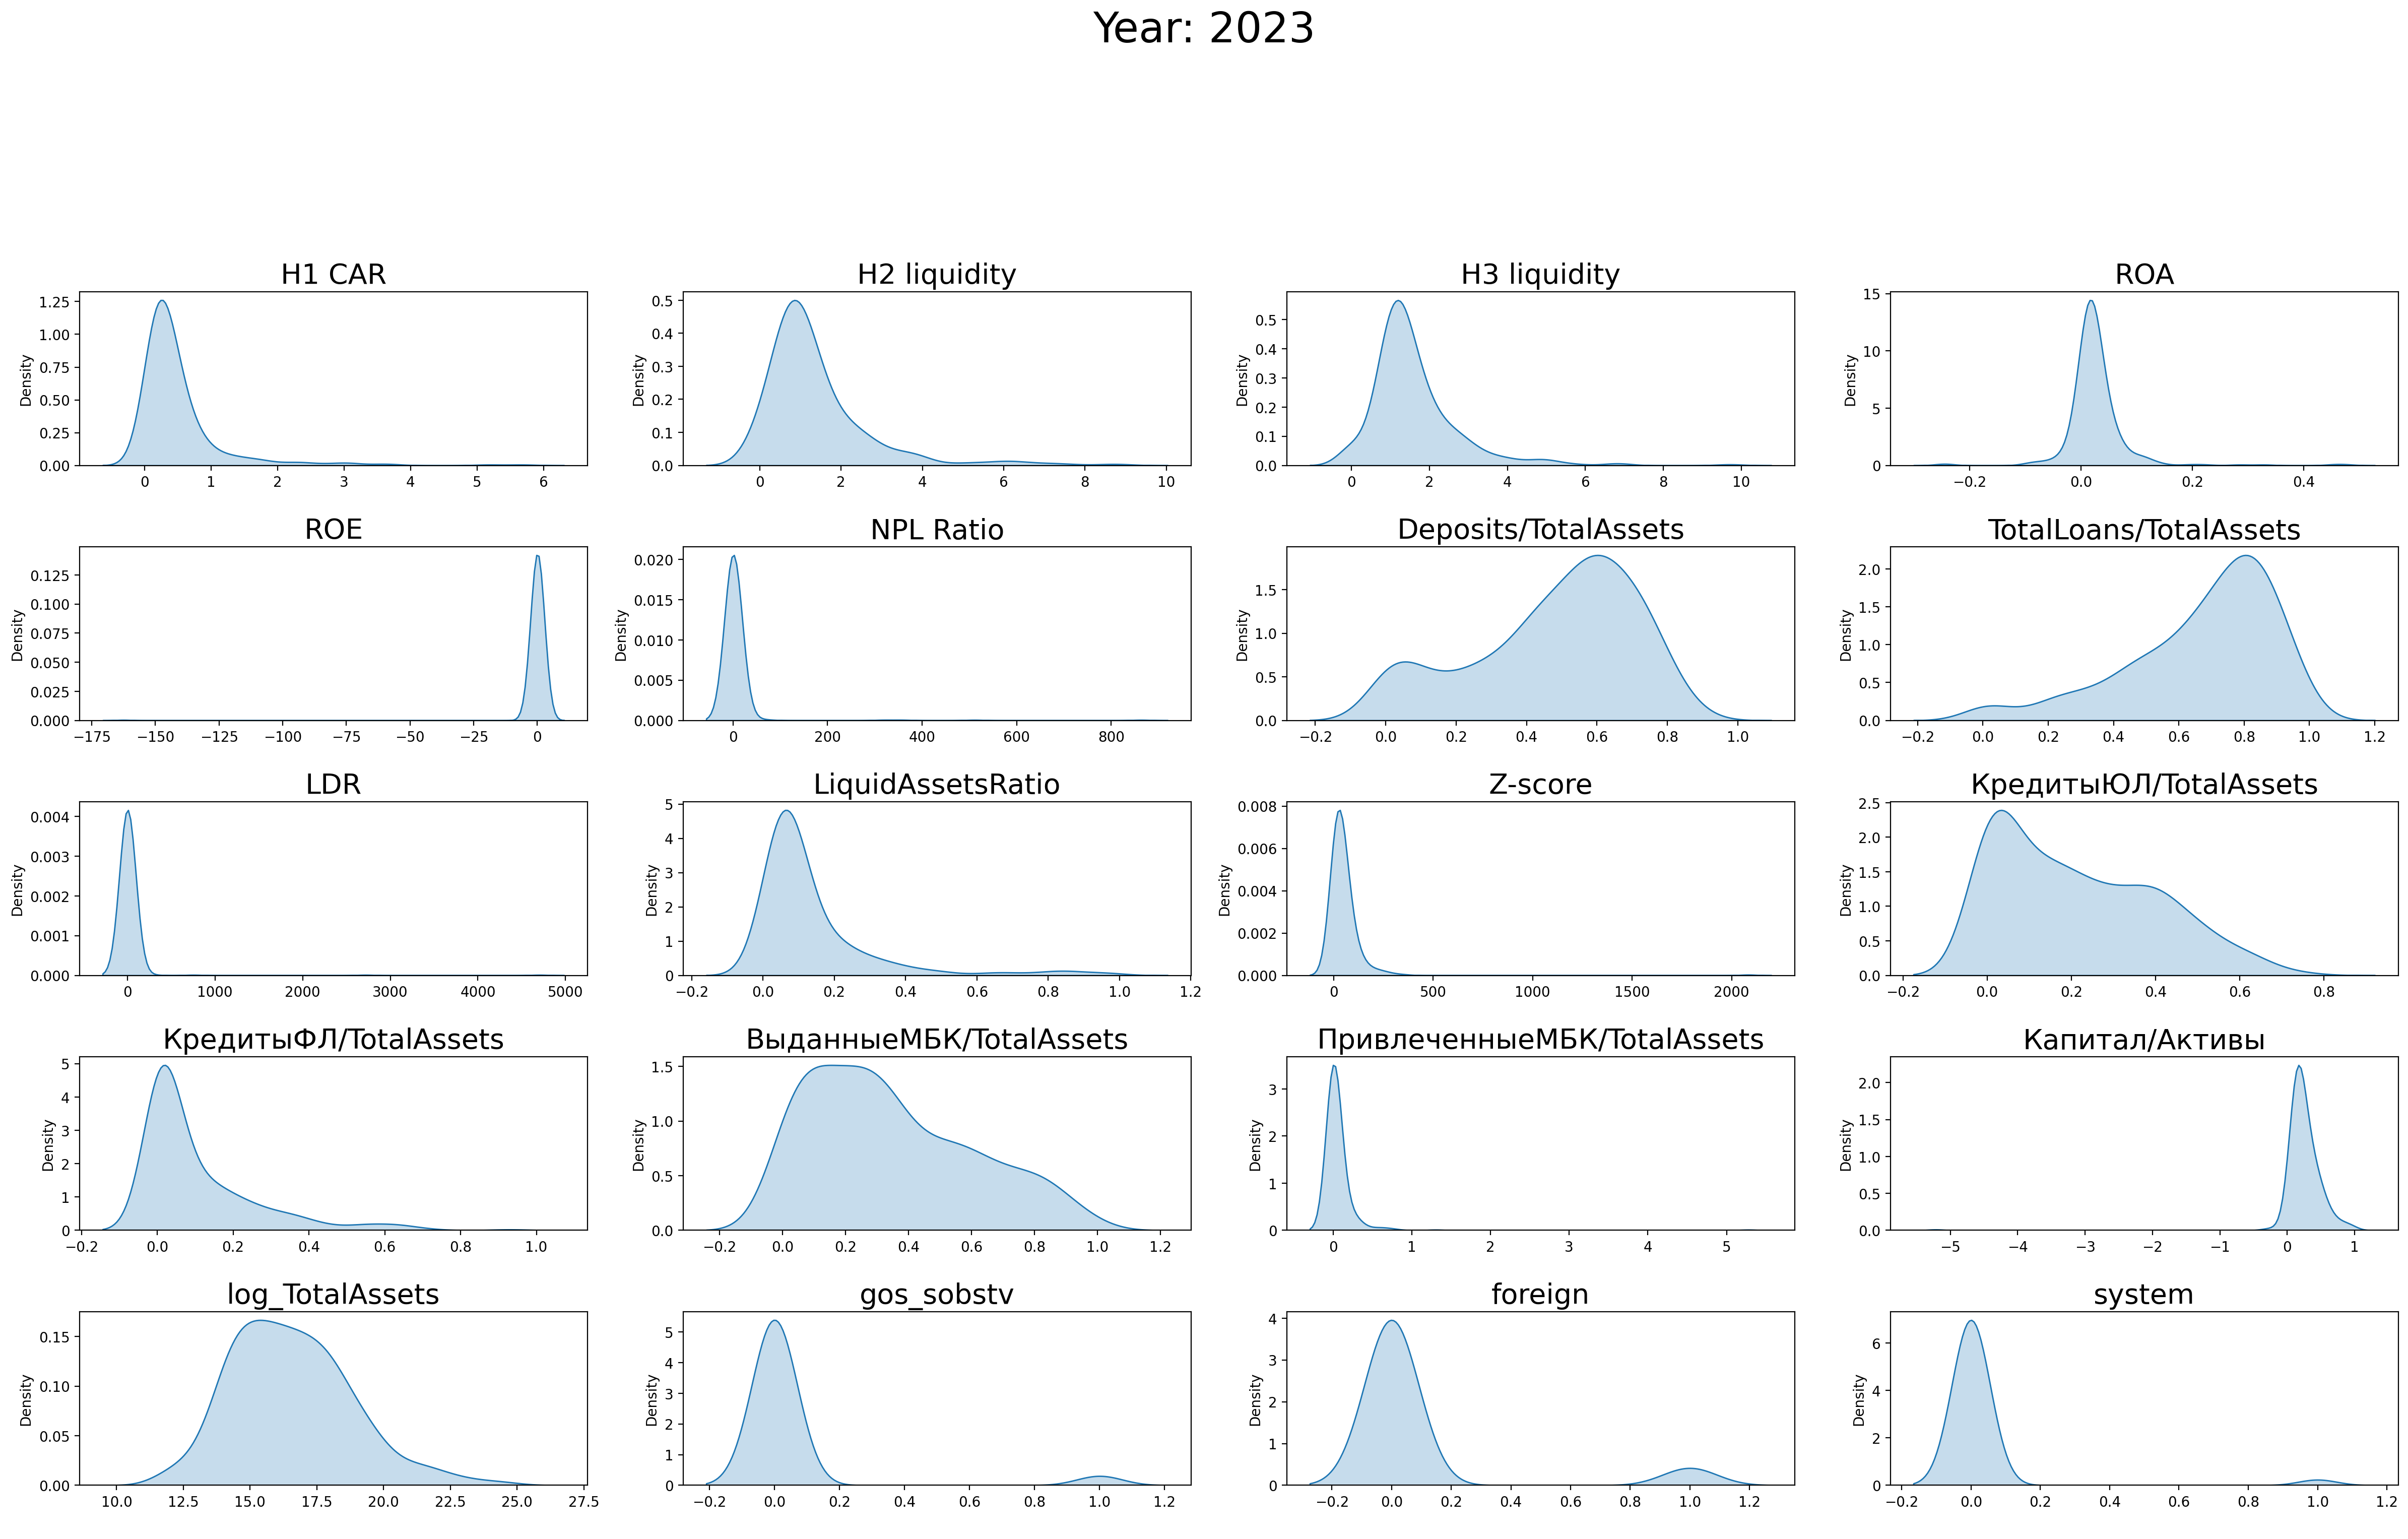

In [214]:
visuals_kdeplot(x_2023.drop(columns = 'bank_name'), year=2023)

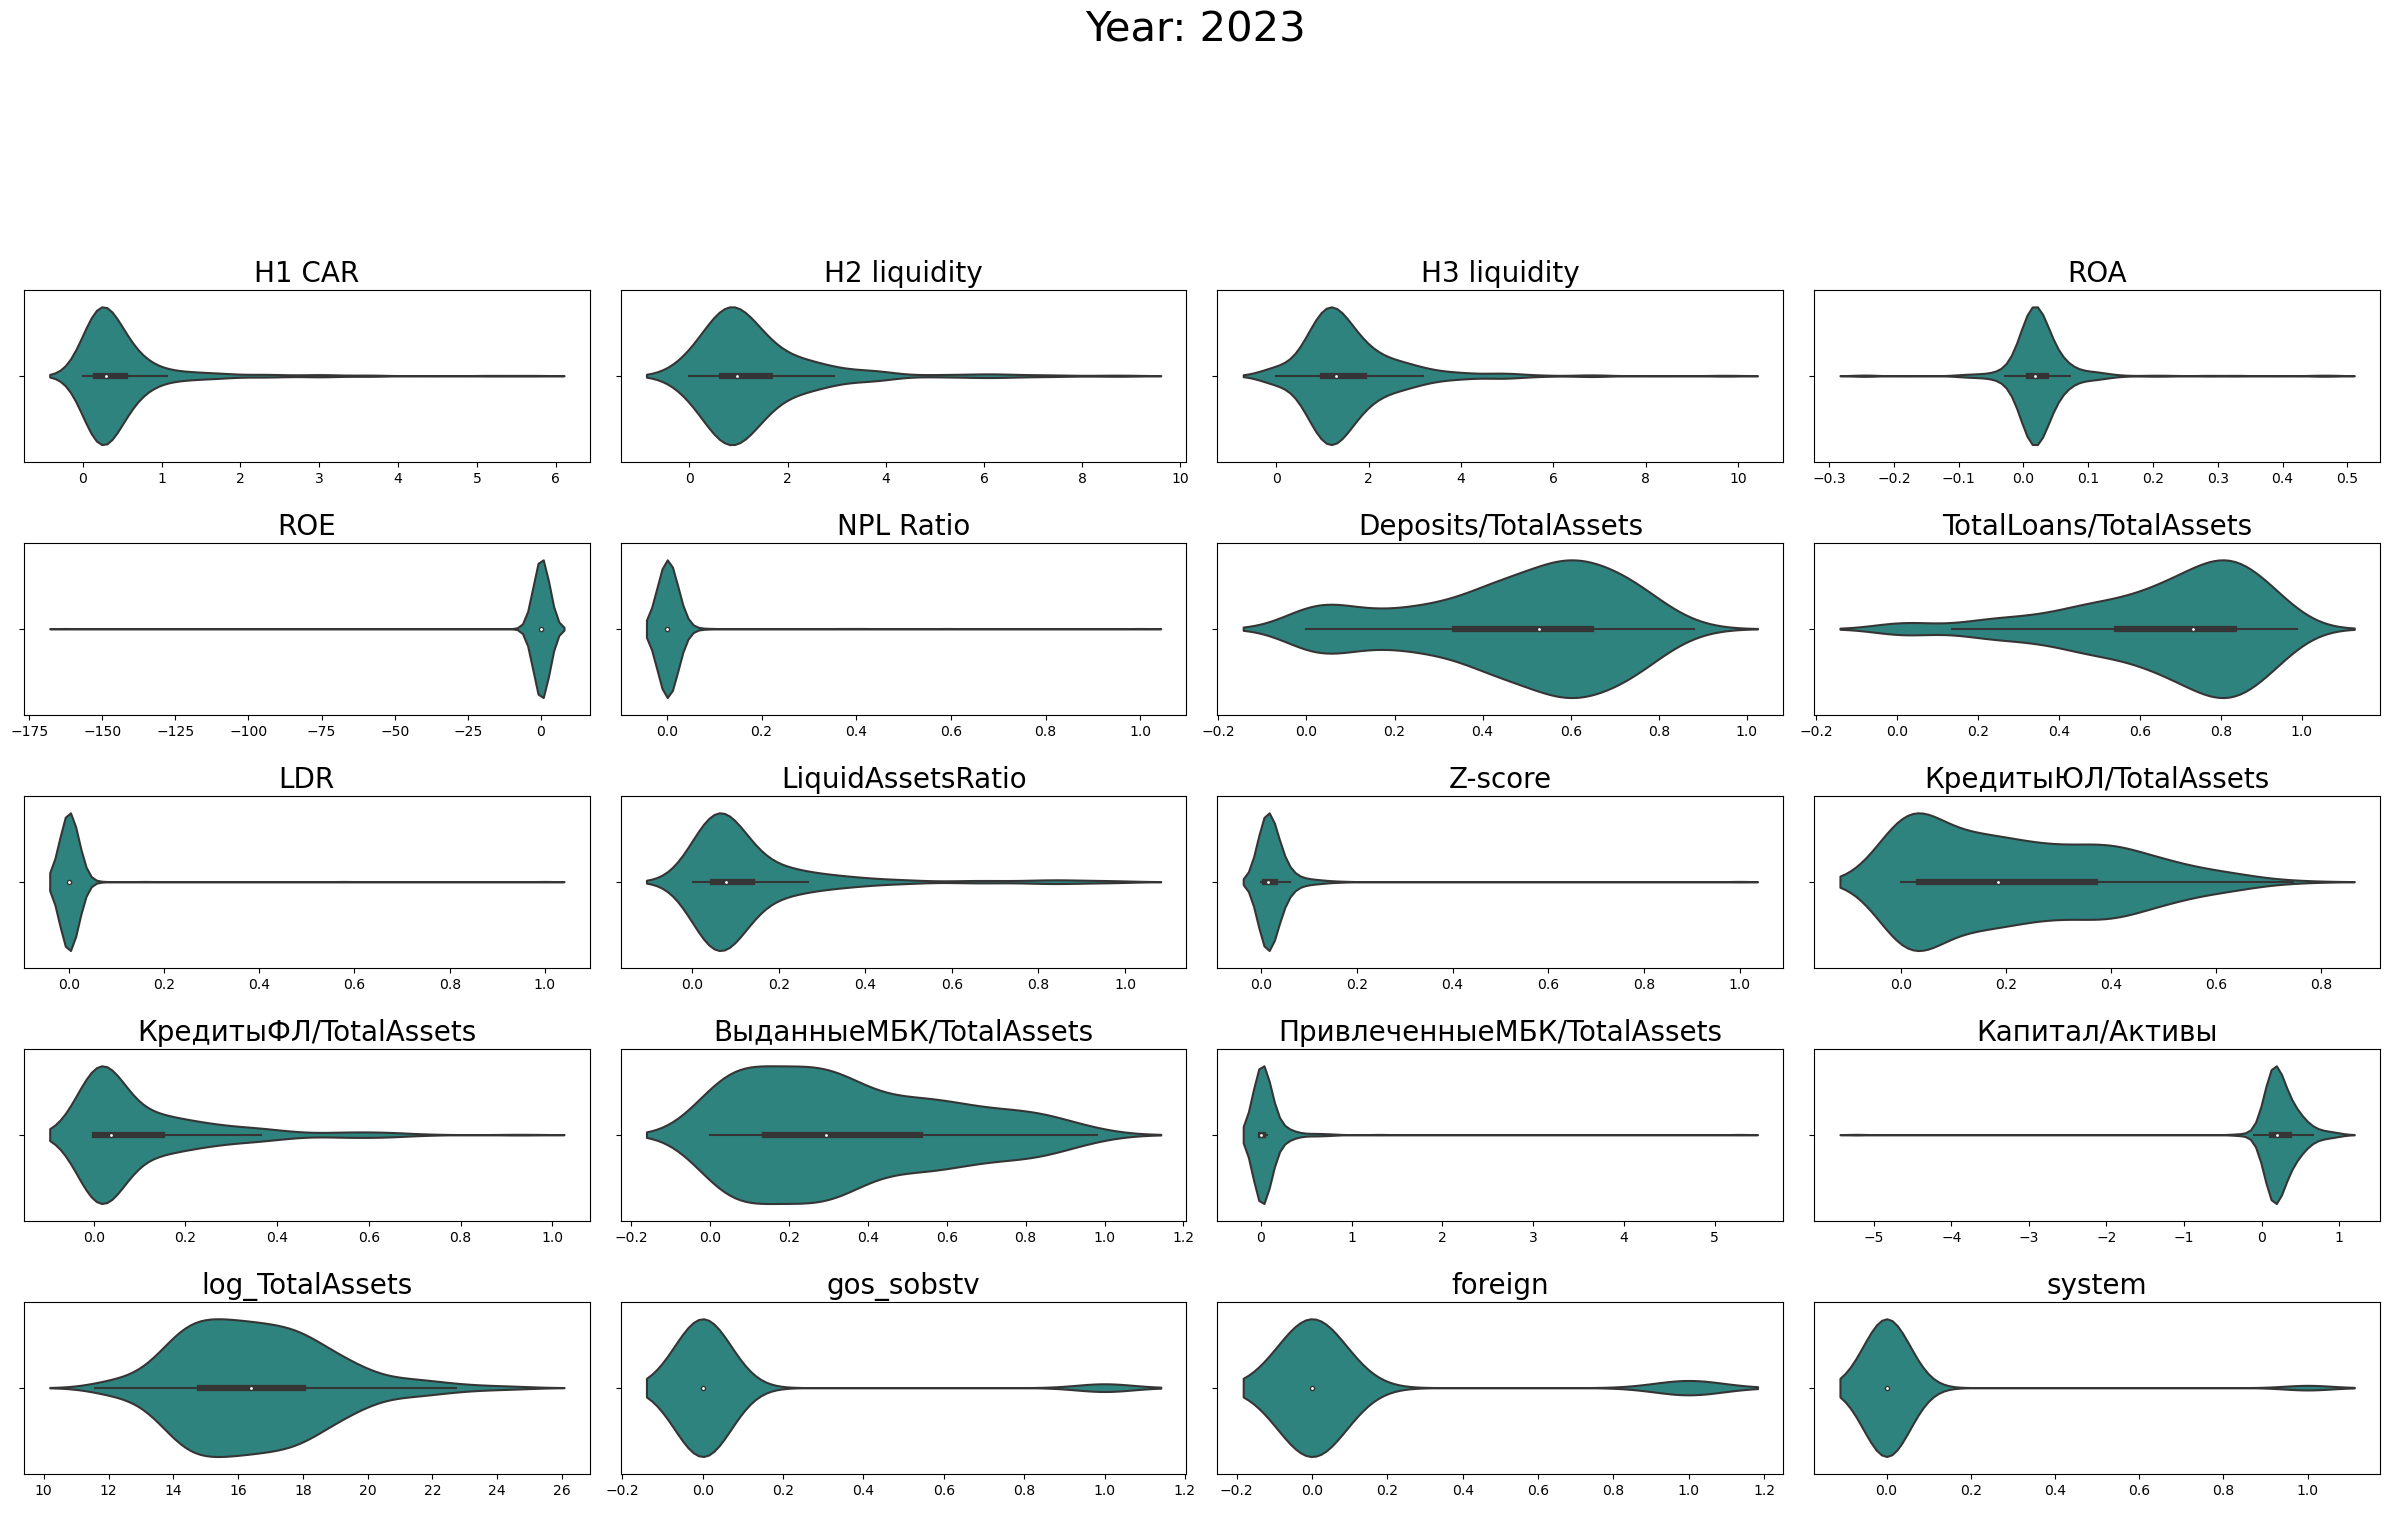

In [64]:
visuals_violinplot(x_2023.drop(columns = 'bank_name'), year=2023)

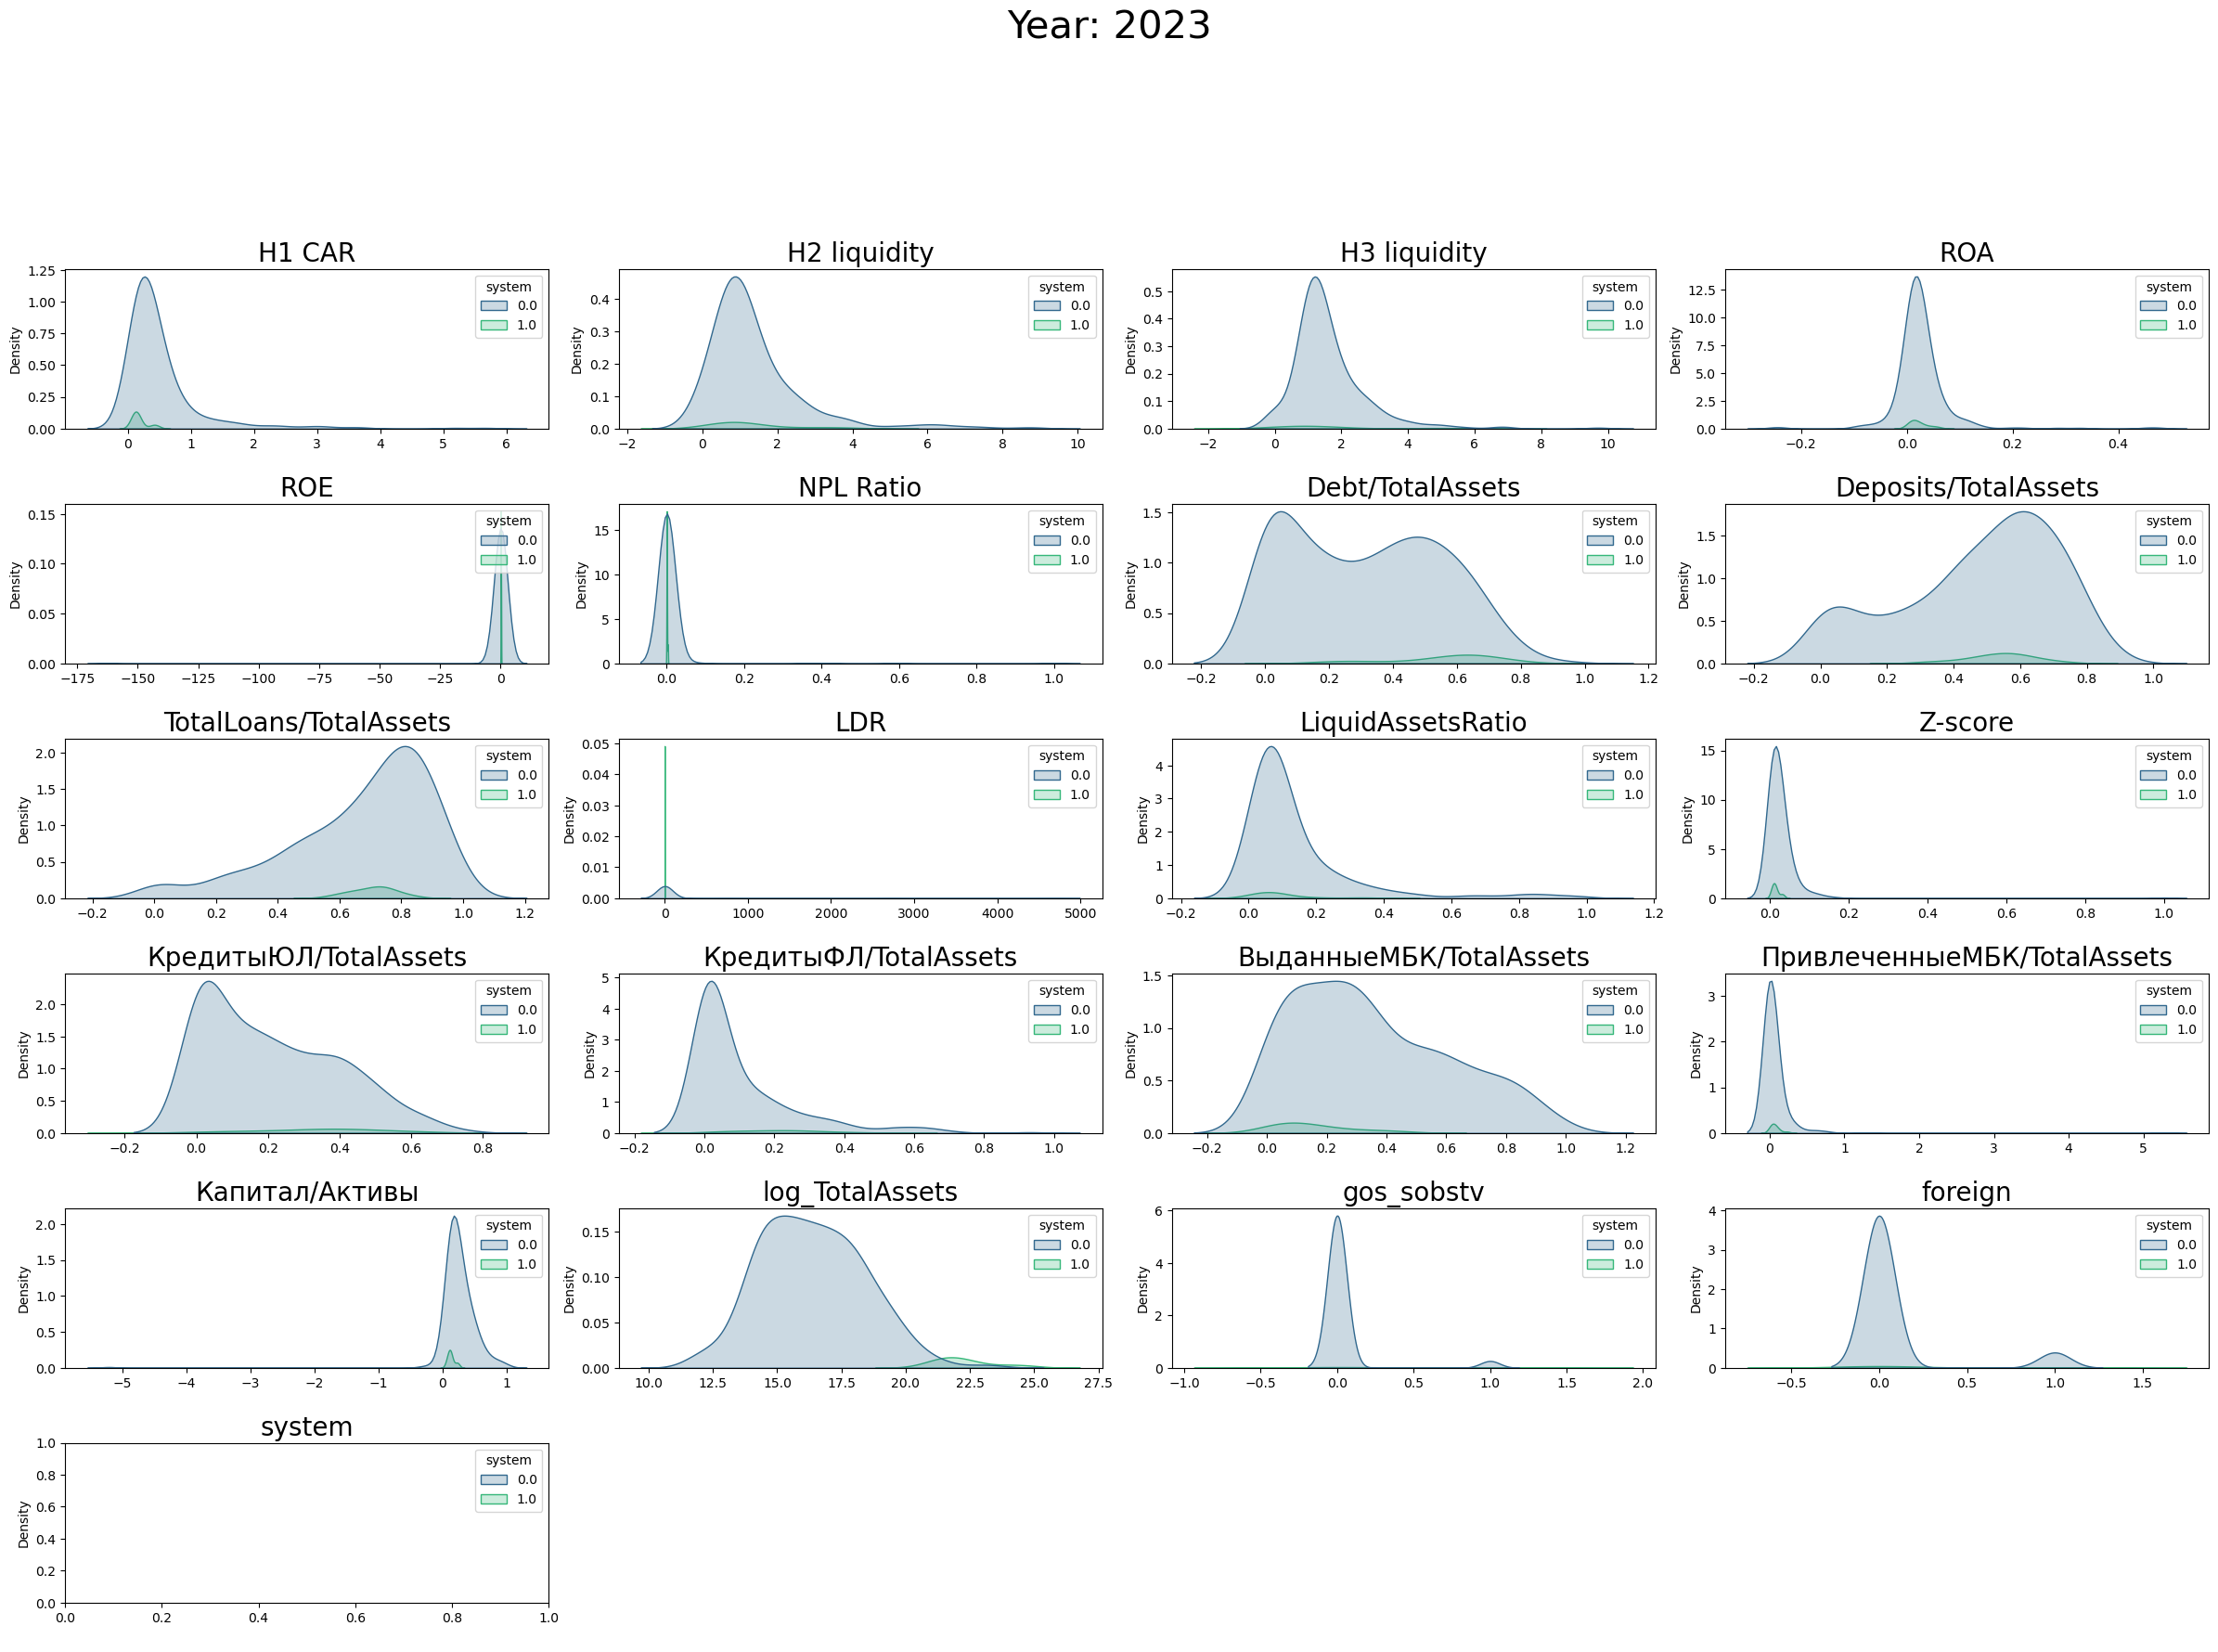

In [25]:
visuals_kdeplot(x_2023.drop(columns = 'bank_name'), hue= True, hue_col='system', year=2023)

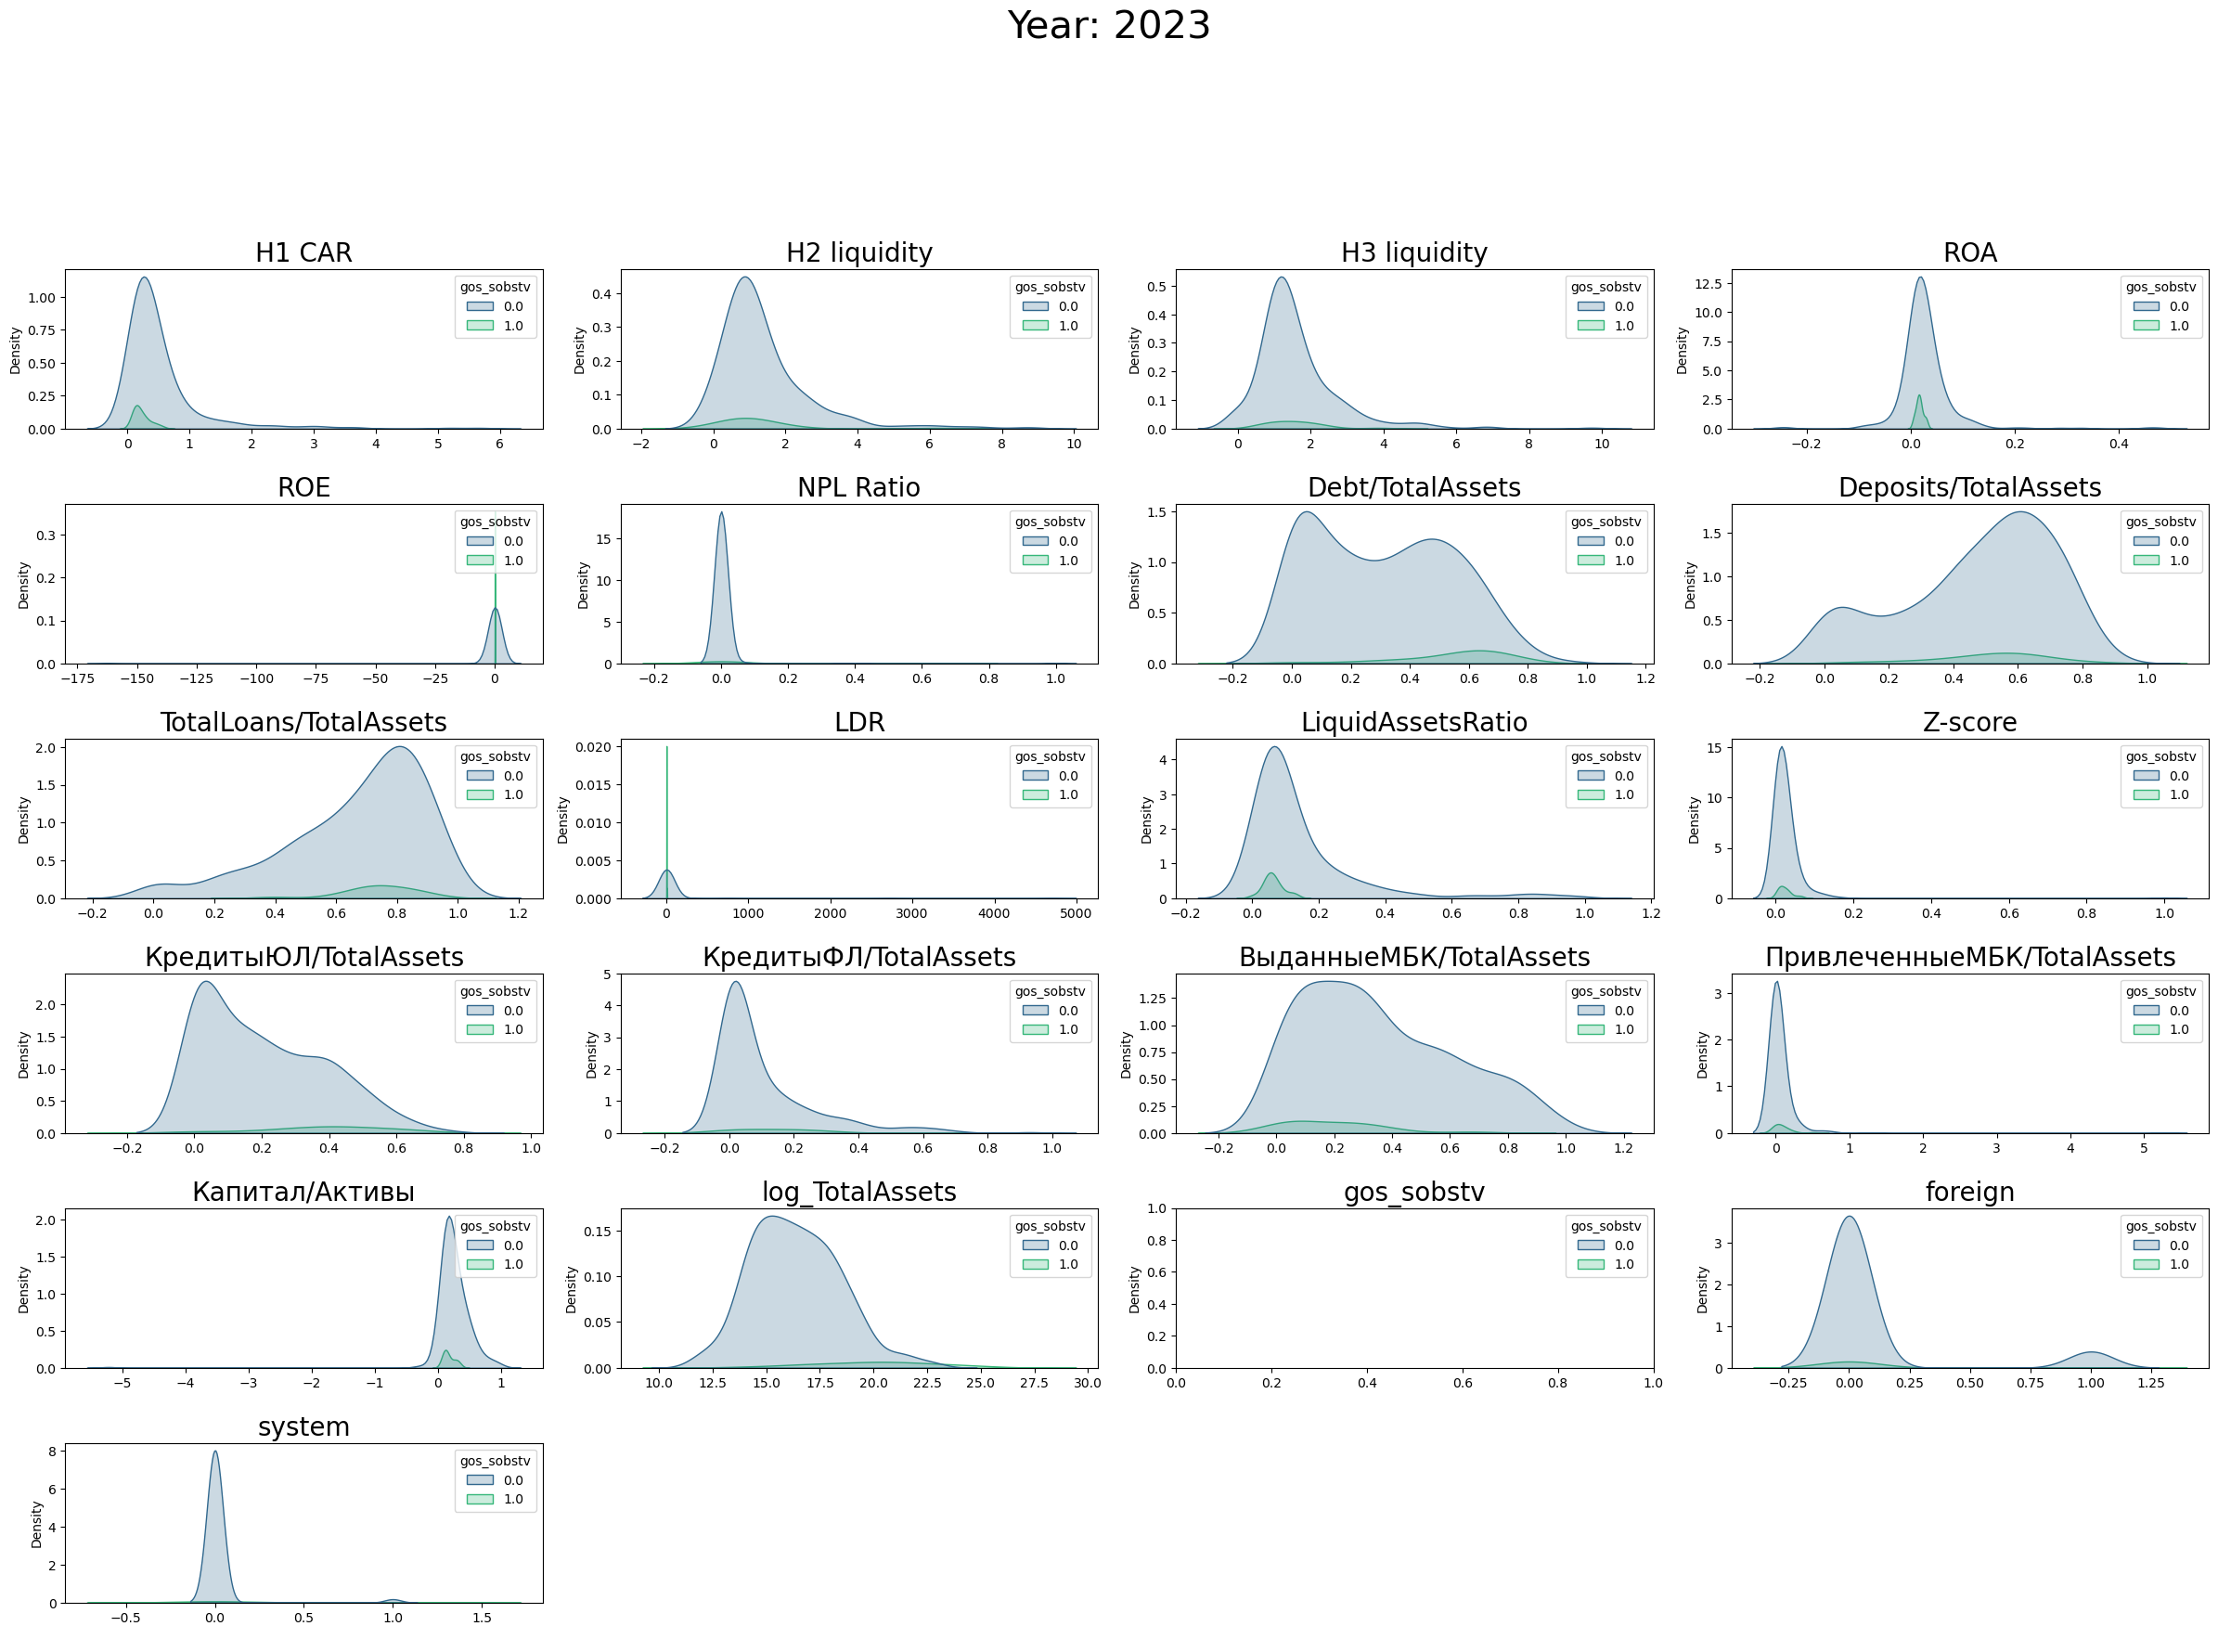

In [26]:
visuals_kdeplot(x_2023.drop(columns = 'bank_name'), hue= True, hue_col='gos_sobstv', year=2023)

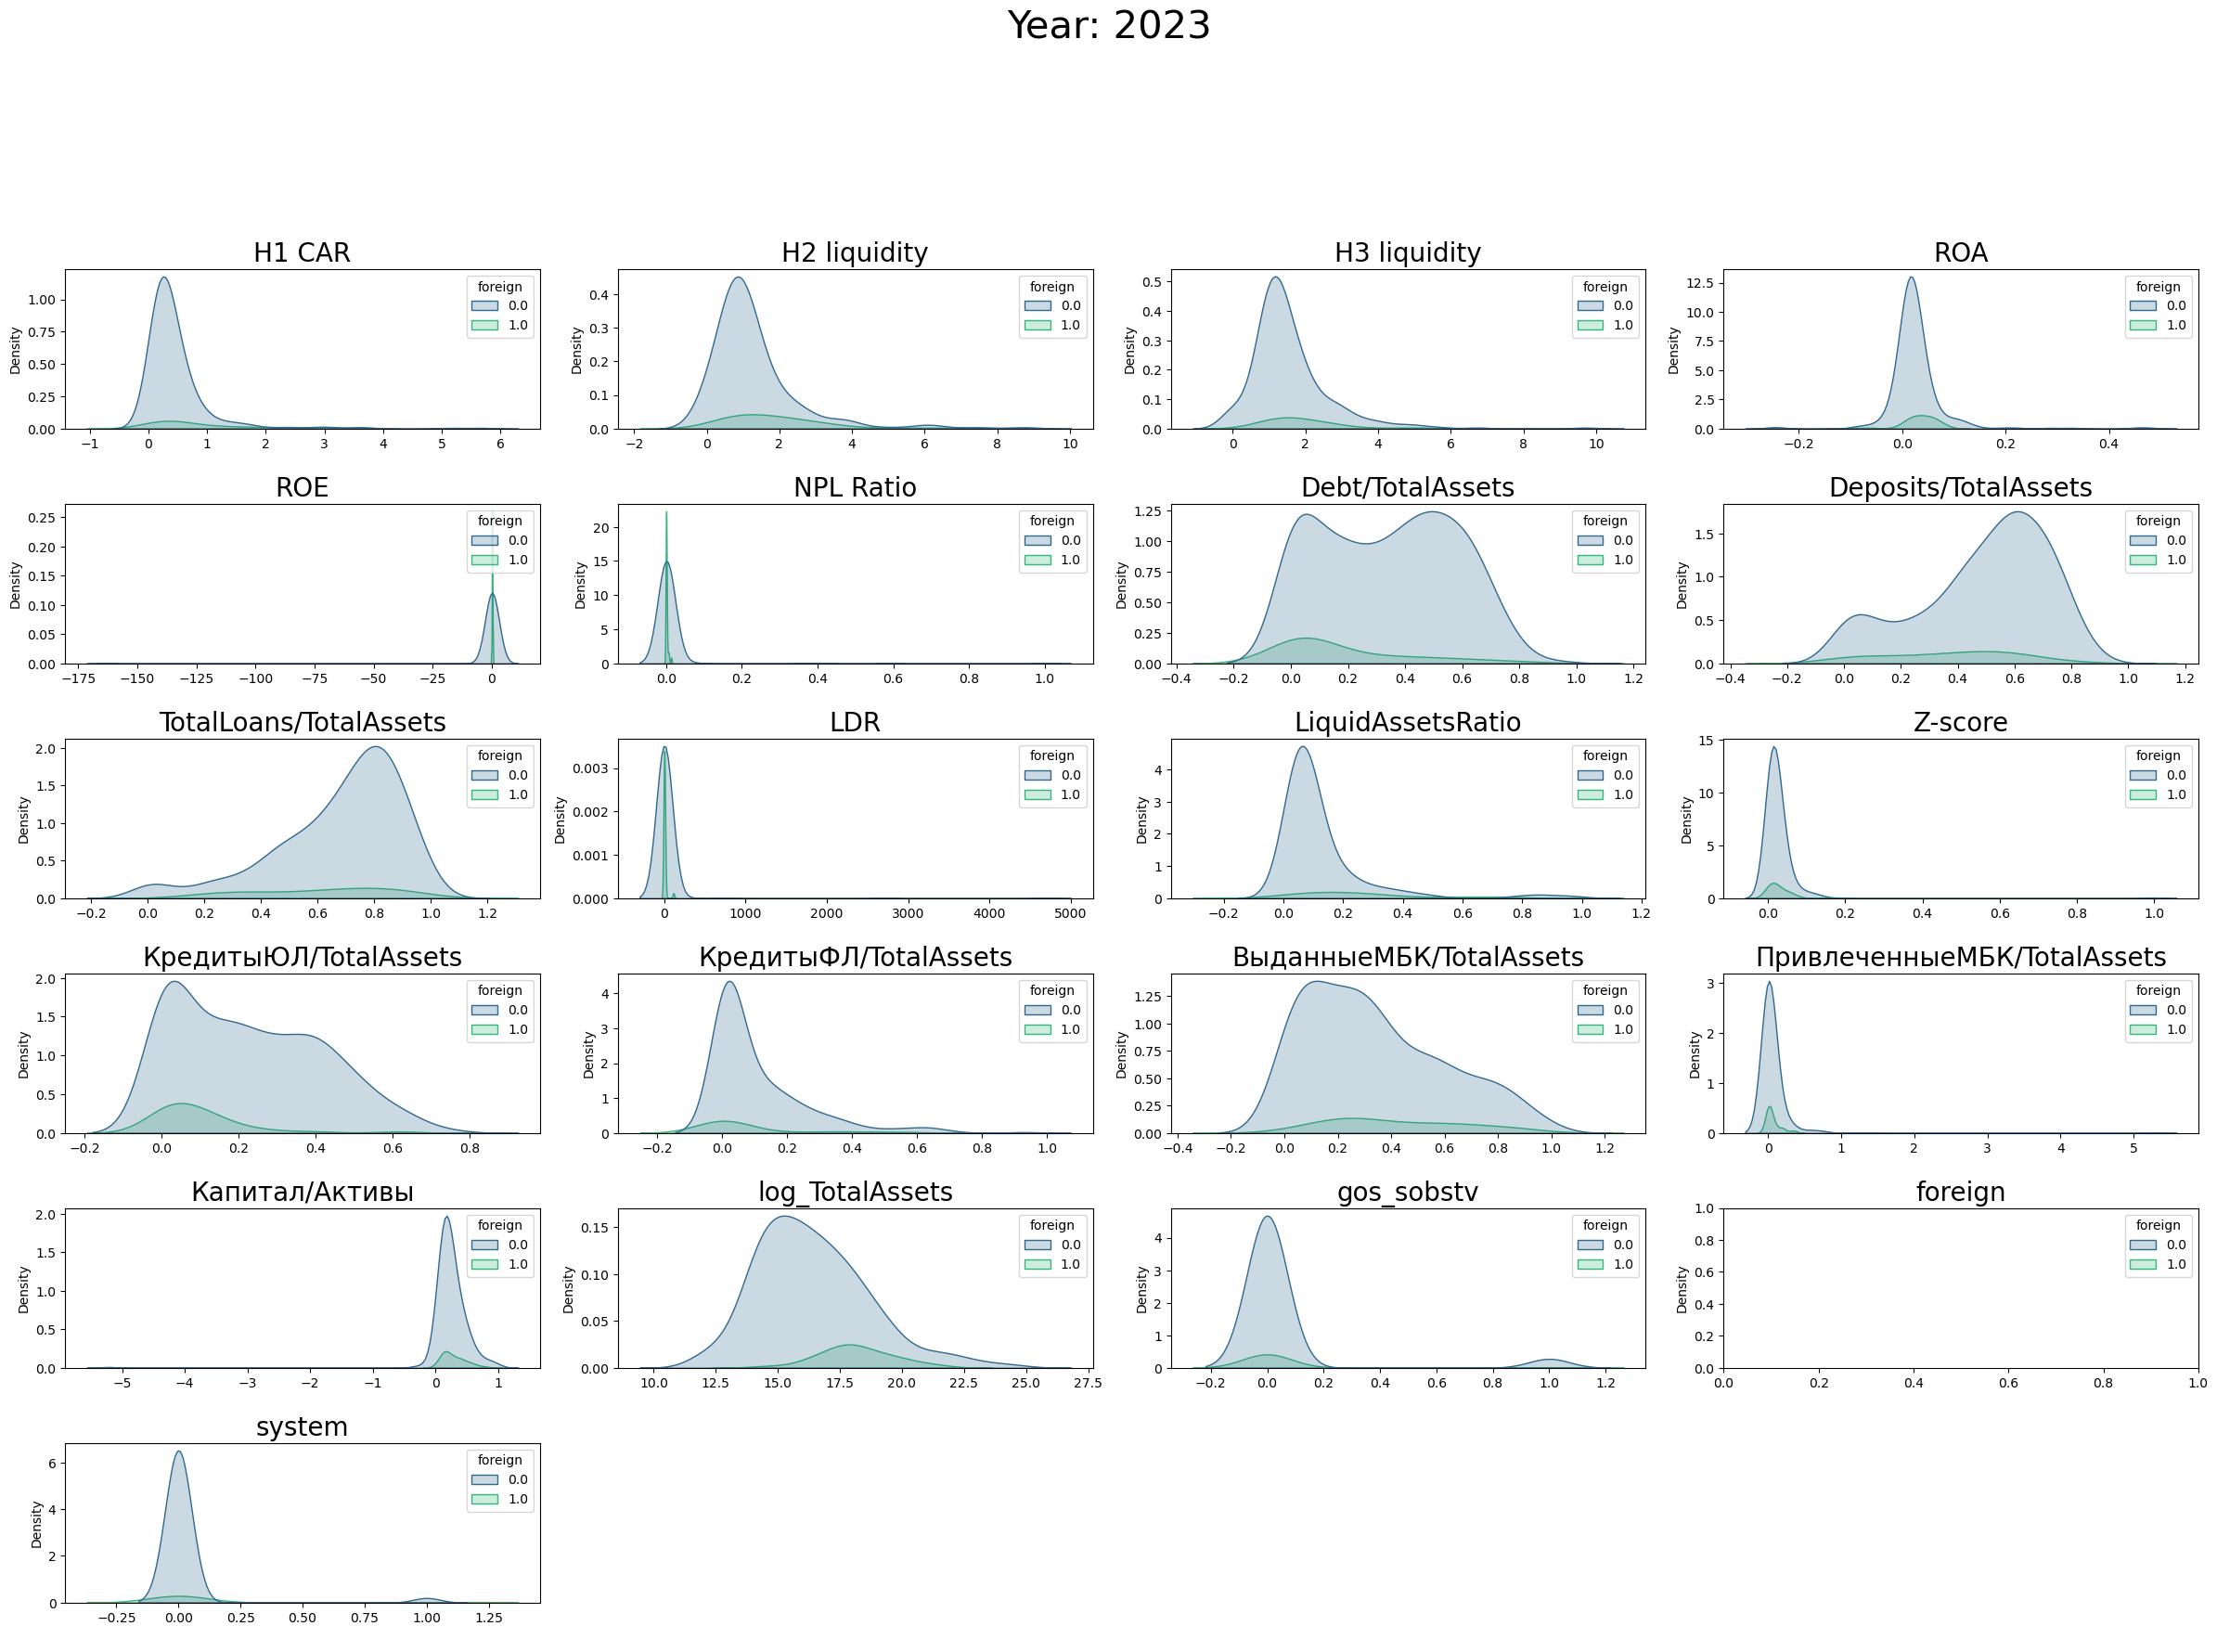

In [27]:
visuals_kdeplot(x_2023.drop(columns = 'bank_name'), hue= True, hue_col='foreign', year=2023)

In [198]:
def visuals_kdeplot_multiyear(df1, df2, df3, df4, hue = False, hue_col = None):
    plt.figure(figsize=(24,28))
    for i in range(0, df3.shape[1]):
        plt.subplot(10,4,i+1)
         
        sns.kdeplot(x=df1[df1.columns[i]], palette='viridis', shade=True, label='2023')
        sns.kdeplot(x=df2[df2.columns[i]], palette='viridis', shade=True, label='2021')
        sns.kdeplot(x=df3[df3.columns[i]], palette='viridis', shade=True, label='2020')
        sns.kdeplot(x=df4[df4.columns[i]], palette='viridis', shade=True, label='2019')
        plt.legend()
        plt.title(df1.columns[i], fontsize=20)
        plt.xlabel(' ')
        plt.tight_layout()
        plt.suptitle('Межгодовое сравнение', fontsize=30)
        plt.subplots_adjust(top=0.88)

In [199]:
x_2023['LTV'] = None
x_2023['NPL Coverage'] = None
x_2023['NPL/TotalLoans'] = None
x_2023 = x_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity', 'ROA', 'ROE', 'LTV',
       'NPL Ratio', 'NPL Coverage', 'Deposits/TotalAssets',
       'TotalLoans/TotalAssets', 'LDR', 'NPL/TotalLoans', 'LiquidAssetsRatio',
       'Z-score', 'КредитыЮЛ/TotalAssets', 'КредитыФЛ/TotalAssets',
       'ВыданныеМБК/TotalAssets', 'ПривлеченныеМБК/TotalAssets',
       'Капитал/Активы', 'log_TotalAssets', 'gos_sobstv', 'foreign', 'system']]

In [65]:
visuals_kdeplot_multiyear(x_2023, x_2021, x_2020, x_2019)

NameError: name 'visuals_kdeplot_multiyear' is not defined

In [203]:
x_2023 = pd.read_excel('full_dfs/x_2023.xlsx')

In [205]:
# [x_2023['Z-score'] < x_2023['Z-score'].max()]

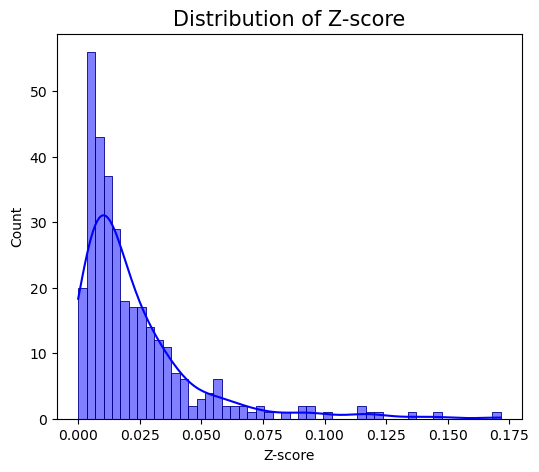

In [51]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Distribution of Z-score', fontsize=15)
sns.histplot(x_2023[x_2023['Z-score'] < x_2023['Z-score'].max()]['Z-score'],
             bins=50,
             ax=ax,
             color='blue',
             edgecolor='darkblue',
             kde = True);

In [53]:
x_2023['Z-score'].quantile(0.05)

0.003156108045131095

In [54]:
x_2023[x_2023['Z-score'] < x_2023['Z-score'].quantile(0.05)]['Z-score'].mean()

0.0020563691627746143

In [207]:
x_2023[x_2023['Z-score'] < x_2023['Z-score'].quantile(0.05)] # рискованные банки

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
24,Уральский банк реконструкции и развития (УБРиР),0.0886,1.0659,1.7754,-0.033055,-0.572836,0.43,0.640746,0.670726,1.046790,0.099444,3.075945,0.190261,0.187995,0.292471,0.038238,0.057703,19.713790,0,0,0
30,«Траст»,0.0000,0.3994,0.7723,0.328926,-0.063047,51.70,0.005740,0.223759,38.980307,0.005143,1.897723,0.156184,0.000060,0.067515,5.277712,-5.217186,19.395601,0,0,0
39,Инвестторгбанк,0.0000,3.9322,3.9462,0.000106,-0.001105,38.19,0.850419,0.409012,0.480953,0.038518,0.012384,0.188800,0.154700,0.065512,0.232782,-0.095838,18.990550,0,0,0
43,Газэнергобанк,0.0002,0.7302,1.0733,-0.021013,-162.453643,1.56,0.395945,0.594308,1.500987,0.048238,-2.157613,0.162568,0.124662,0.307077,0.557946,0.000129,18.791730,0,0,0
50,Таврический Банк,0.0000,1.1871,0.5366,0.085155,-0.316912,863.61,0.649379,0.028961,0.044598,0.033815,2.434192,0.023142,0.005790,0.000029,0.657784,-0.268702,18.648918,0,0,0
57,Национальный Резервный Банк,0.3011,0.7658,1.2258,0.035922,0.355875,0.01,0.197232,0.318587,1.615293,0.348028,4.410238,0.027818,0.000766,0.290003,0.164104,0.100941,18.381633,0,0,0
66,ВУЗ-банк,0.0000,0.3157,0.5590,-0.241509,0.804715,5.21,0.091934,0.653883,7.112538,0.028992,-1.612909,0.283661,0.340996,0.029226,1.305042,-0.300117,18.080130,0,0,0
109,Экономбанк,0.0000,0.5876,0.8105,-0.012275,0.138698,72.66,0.822923,0.198193,0.240840,0.028800,-1.028934,0.195718,0.002475,0.000000,0.290136,-0.088502,17.093613,0,0,0
117,Банк «МБА-МОСКВА»,0.5402,0.6715,1.1706,0.032446,0.083294,0.00,0.136253,0.462927,3.397566,0.203199,4.099783,0.133895,0.001209,0.327823,0.085928,0.389531,16.868639,0,1,0
149,«Гарант-Инвест»,0.1458,2.0221,2.3068,-0.036263,-0.251683,1.21,0.571703,0.650271,1.137429,0.124127,2.344183,0.648274,0.001998,0.000000,0.081720,0.144084,16.256812,0,0,0


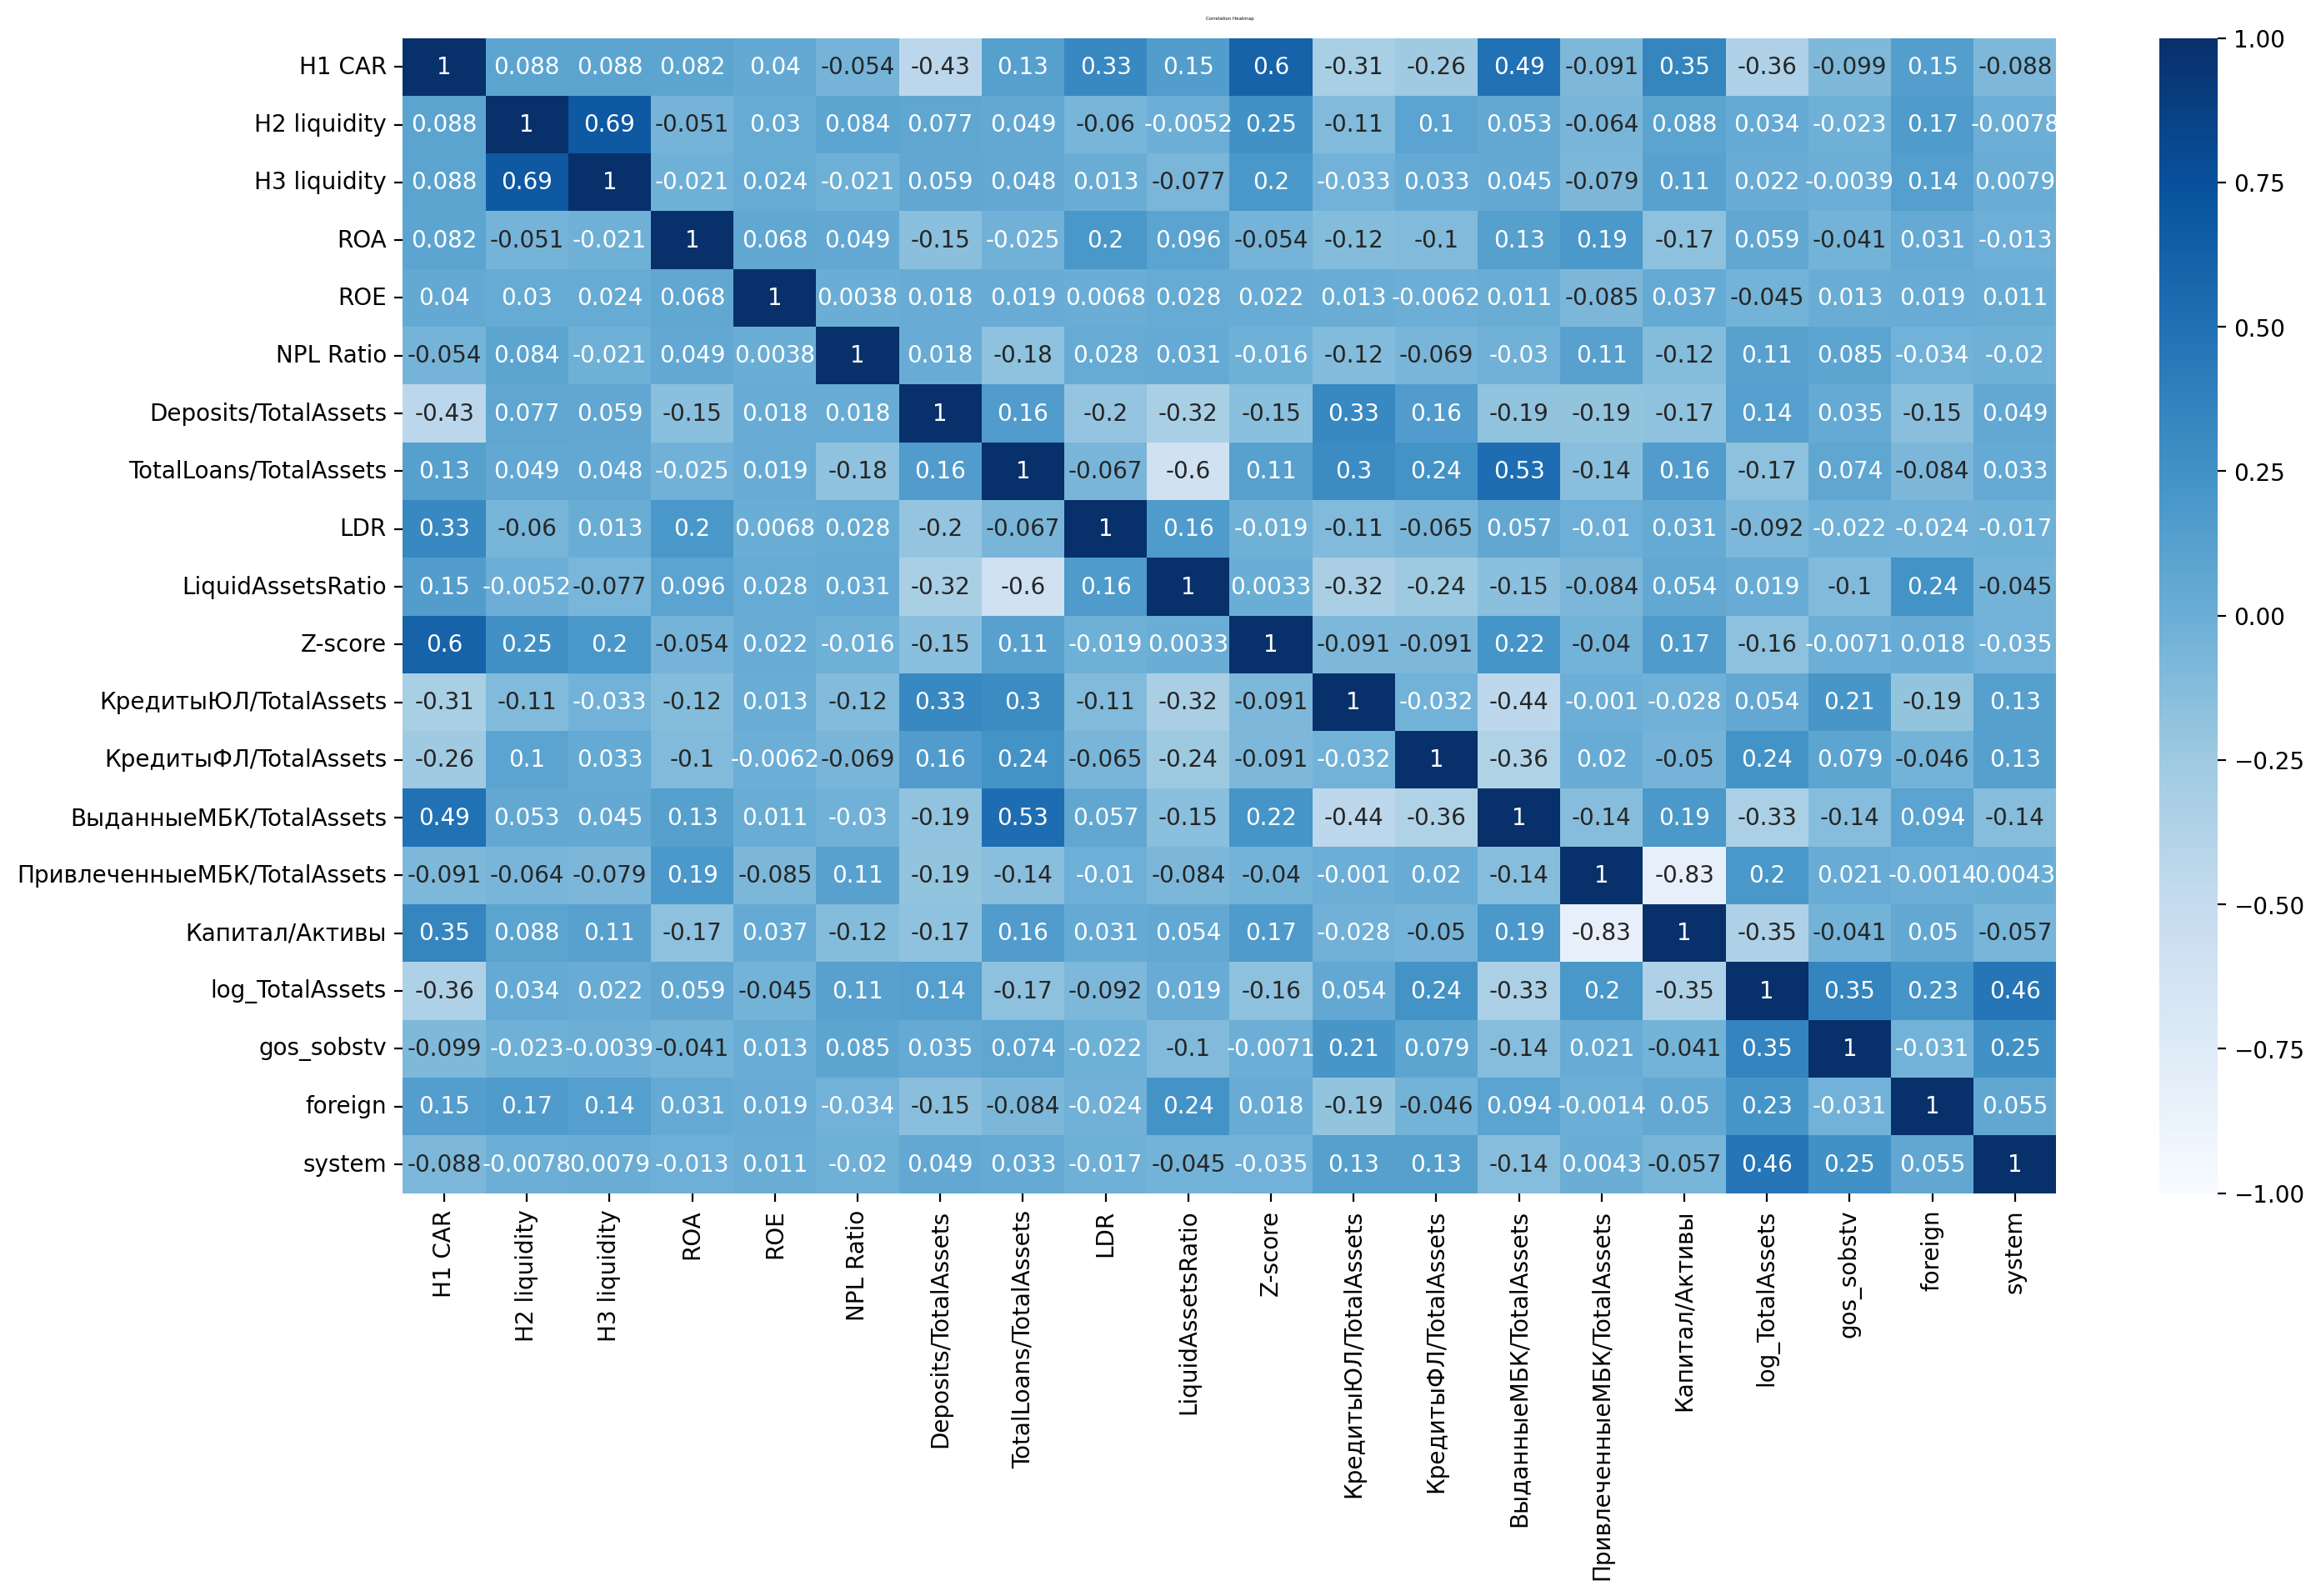

In [208]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(x_2023.drop(columns = 'bank_name').corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':2}, pad=8);